<a href="https://colab.research.google.com/github/LePhongCongThanh/Predict-Demand-of-Using-Bikes-in-An-Urban/blob/main/Bulding_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#***CAPSTONE DESIGN: PREDICT THE DEMAND OF USING BIKES IN AN URBAN AREA***
*4/2023*           
***Thanh Le***

>***The goal of this project is to see the effects of environment factors on using bikes.*** 
>>***This dataset from Kaggle includes weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.***
>> ***https://bom.so/wcdpIO***



##***1.Import libraries and dataset***

In [ ]:
import numpy as np
import pandas as pd
import re
from typing import Tuple, Type

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Or any other font that supports Georgian script


from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.api as sm

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


# For execution time calculation
from datetime import datetime
from datetime import timedelta
import random
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#importing different Regression models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
bike_demand = pd.read_csv('https://raw.githubusercontent.com/LePhongCongThanh/Predict-Demand-of-Using-Bikes-in-An-Urban/main/SeoulBikeData%20(1).csv', encoding= 'unicode_escape')
bike_demand.info()
bike_demand.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


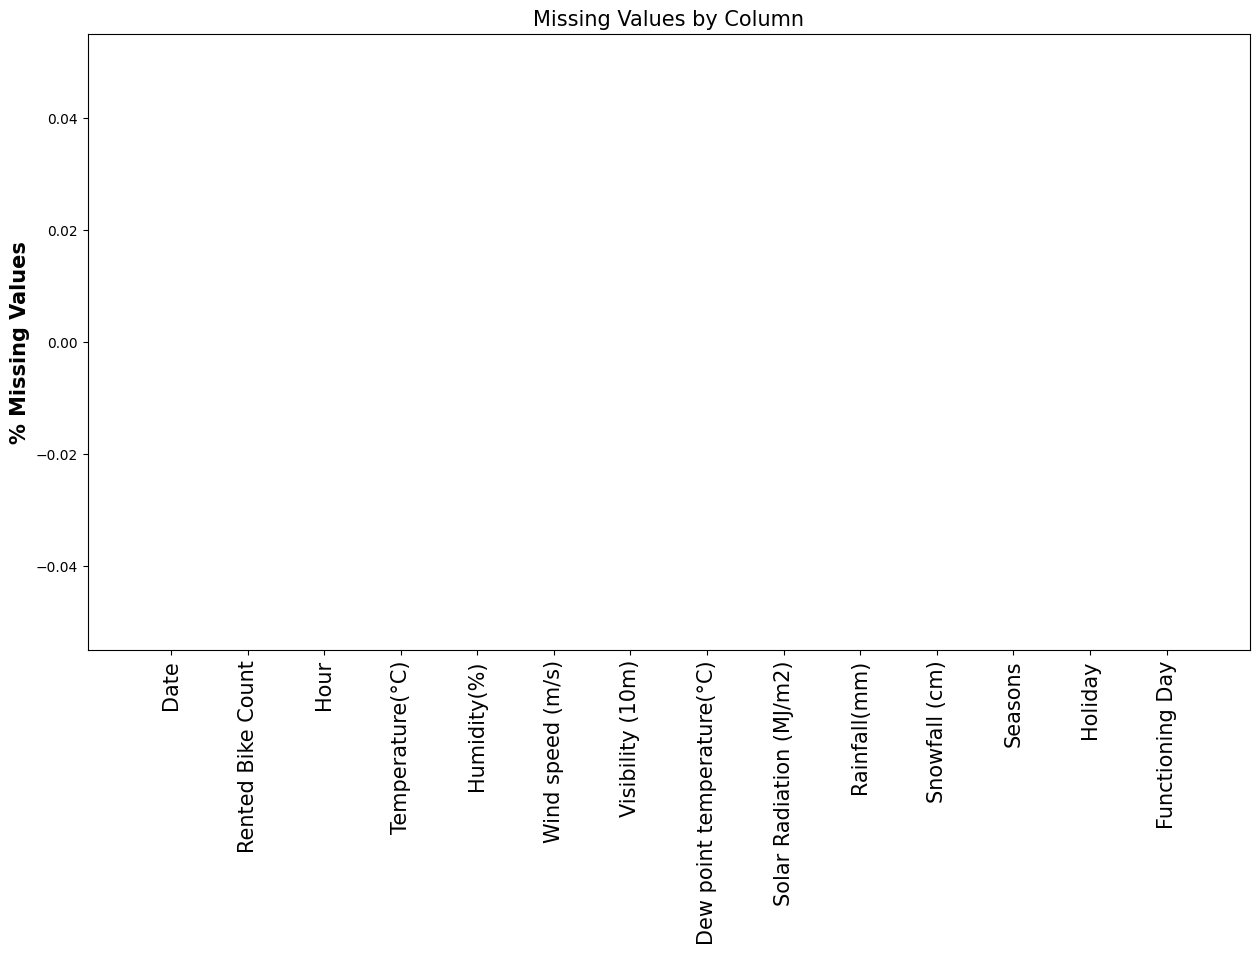

In [ ]:
# Plot a bar chart of the missing percentages
missing_pct = (bike_demand.isnull().sum() / len(bike_demand)) * 100
missing_pct = missing_pct.sort_values(ascending=False) # Sort columns by percentage of missing values
plt.figure(figsize=(15, 8))
plt.bar(missing_pct.index, missing_pct.values)
plt.xticks(rotation=90, fontsize=15)
plt.ylabel('% Missing Values',fontsize=15 ,fontweight='bold')
plt.title('Missing Values by Column',fontsize=15)
plt.show();

>*This dataset has a shape of 8760 rows(observations) X 14 columns(features).*

>*Therein, there are 10 features of numeric dtype (int, float) and 4 features of categorical dtype (object).*

>>*However, the feature of "Date" can be transformed from "object" into "date" dtype. This transformation will be performed after checking missing values (completed in 2.1.2).*

>>*This dataset does not include "ID" column that is very important to identify uniquely each observation. Thus, the Index will be set as a "ID" column (completed in 2.1.2).*

>>*Moreover, the info of this dataset shows that there are no features having missing values, but this is only right with features of numeric datatypes. For features of object dtype may have misssing values of shape of "-", ".",... Thus, it's needed to check carefully features of object dtype (completed in 2.1.1).*

##***2. Data cleaning and pre-processing***


###***2.1 Missing Values***

In [ ]:
# Select columns of object dtypes
cols_object = bike_demand.select_dtypes(include=['object']).columns.to_list()

# Loop through each cols_object
for col in cols_object:
  value_counts = bike_demand[col].value_counts().sort_index()
  print(f'Values of {col} are:')
  print(value_counts)

Values of Date are:
01/01/2018    24
01/02/2018    24
01/03/2018    24
01/04/2018    24
01/05/2018    24
              ..
31/05/2018    24
31/07/2018    24
31/08/2018    24
31/10/2018    24
31/12/2017    24
Name: Date, Length: 365, dtype: int64
Values of Seasons are:
Autumn    2184
Spring    2208
Summer    2208
Winter    2160
Name: Seasons, dtype: int64
Values of Holiday are:
Holiday        432
No Holiday    8328
Name: Holiday, dtype: int64
Values of Functioning Day are:
No      295
Yes    8465
Name: Functioning Day, dtype: int64


>*Use method "sort_index()" to filter missing values having shapes of  "-","..." , but there are no values like that. Thus, it can conclude that there are really no missing values in "object" cols.*

>*For numeric cols, the info shows that these cols have 8760 non-null values and dtypes of numeric (int, float). From this, it's enough to conclude that there are certainly no missing value in num cols without checking carefully like object cols.*

###***2.2 Set ID column and tranform dtype of Date column***

In [ ]:
# Add "ID" column and move column "ID" to the first position
def transform_add(df: pd.DataFrame) -> pd.DataFrame:
  df["ID"] = df.index # add "ID" col at the last postion
  col_ID = df.pop("ID") # remove column "ID" and return as a Series object
  df.insert(0, "ID", col_ID) # insert the Series object as column 0
  df["Date"] = df["Date"].astype("datetime64") #transform datetime
  return df.info(), df.head()
transform_add(bike_demand)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         8760 non-null   int64         
 1   Date                       8760 non-null   datetime64[ns]
 2   Rented Bike Count          8760 non-null   int64         
 3   Hour                       8760 non-null   int64         
 4   Temperature(°C)            8760 non-null   float64       
 5   Humidity(%)                8760 non-null   int64         
 6   Wind speed (m/s)           8760 non-null   float64       
 7   Visibility (10m)           8760 non-null   int64         
 8   Dew point temperature(°C)  8760 non-null   float64       
 9   Solar Radiation (MJ/m2)    8760 non-null   float64       
 10  Rainfall(mm)               8760 non-null   float64       
 11  Snowfall (cm)              8760 non-null   float64       
 12  Season

<ipython-input-5-4fbcbfded1d6>:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df["Date"] = df["Date"].astype("datetime64") #transform datetime


(None,
    ID       Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
 0   0 2017-01-12                254     0             -5.2           37   
 1   1 2017-01-12                204     1             -5.5           38   
 2   2 2017-01-12                173     2             -6.0           39   
 3   3 2017-01-12                107     3             -6.2           40   
 4   4 2017-01-12                 78     4             -6.0           36   
 
    Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
 0               2.2              2000                      -17.6   
 1               0.8              2000                      -17.6   
 2               1.0              2000                      -17.7   
 3               0.9              2000                      -17.6   
 4               2.3              2000                      -18.6   
 
    Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
 0                      0.0           0

>*ID column has been added at the first position and dtype of date col has been transformed*

###***2.3 Check value counts of object cols*** 

>*It's needed to check values of each cols. At least, values of each column are reasonable with the its title.*  

In [ ]:
# Split cols into 2 types of col
object_col = bike_demand.select_dtypes(include="object")
# Loop through cols
for col in object_col.columns.to_list(): 
  values = bike_demand[col].value_counts().sort_values(ascending=True)
  print(f'values of {col} are:')
  print(values)

values of Seasons are:
Winter    2160
Autumn    2184
Spring    2208
Summer    2208
Name: Seasons, dtype: int64
values of Holiday are:
Holiday        432
No Holiday    8328
Name: Holiday, dtype: int64
values of Functioning Day are:
No      295
Yes    8465
Name: Functioning Day, dtype: int64


>*The values of cols of object dtypes are match with its title*

<ipython-input-7-a3f202fabab2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.index);
<ipython-input-7-a3f202fabab2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.index);
<ipython-input-7-a3f202fabab2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.index);


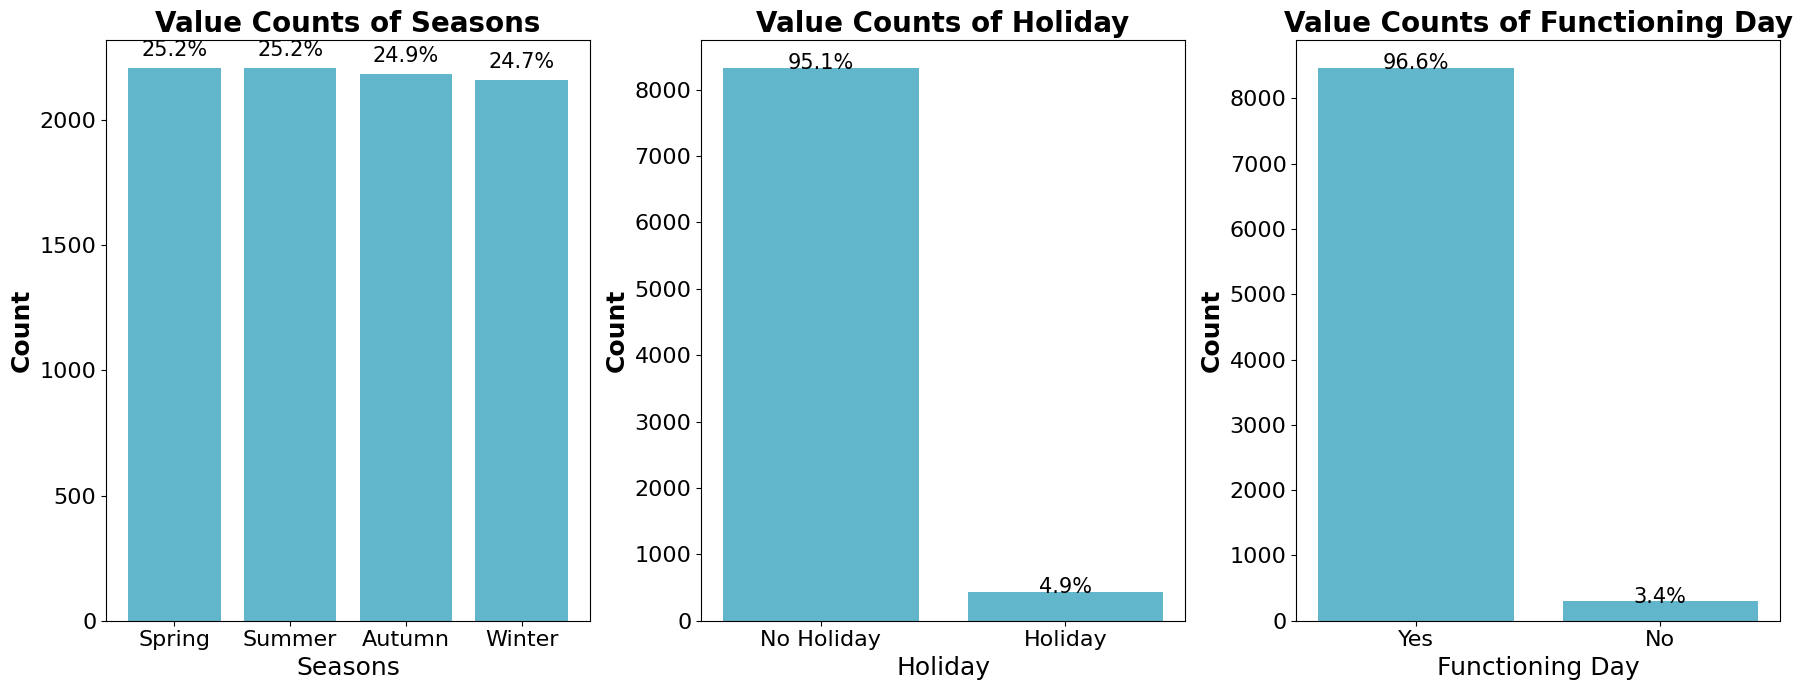

In [ ]:

# Create a figure and subplots
fig, axes = plt.subplots(1,3, figsize=(18, 7))
axes = axes.flatten()

# Loop through each column in the dataframe
for i, col in enumerate(object_col.columns.to_list()):
    counts = bike_demand[col].value_counts()  # Get the value counts for the column
    ax = axes[i]  # Get the subplot
    ax.bar(counts.index, counts.values, color='#62b6cb')  # Create a bar chart of the counts
    ax.set_title(f'Value Counts of {col}', fontsize=20, fontweight='bold')  # Add a title to the subplot
    ax.set_xlabel(col, fontsize=18)  # Add a label to the x-axis
    ax.set_ylabel('Count', fontsize=18, fontweight='bold')  # Add a label to the y-axis
    ax.set_xticklabels(counts.index);
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
     # Add percentage labels to the bars
    for j, count in enumerate(counts):
        ax.text(j, count+0.008*counts.sum(), f"{count/counts.sum()*100:.1f}%", ha="center", va="center", fontsize=15)

# Adjust the spacing of the subplots
fig.tight_layout()


# Show the plot
plt.show();

>*There are no problems with "Seasons", "Holiday", "Functioning Day" columns. In "Holiday" and "Functioning day" columns, values of both "No Holiday' and "Yes Functioning day" account for 9x%. That's makesense in reality.*

>*It's needed to check insight of the column "Holiday" and "Functioning day" to see on what day rented bike is more than. From that, it shows how types of day affect rented bike.*

<Figure size 1800x1800 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rented Bike Count')

<Axes: xlabel='Seasons', ylabel='Rented Bike Count'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Hour')

<Axes: xlabel='Seasons', ylabel='Hour'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Temperature(°C)')

<Axes: xlabel='Seasons', ylabel='Temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Humidity(%)')

<Axes: xlabel='Seasons', ylabel='Humidity(%)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Wind speed (m/s)')

<Axes: xlabel='Seasons', ylabel='Wind speed (m/s)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Visibility (10m)')

<Axes: xlabel='Seasons', ylabel='Visibility (10m)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Dew point temperature(°C)')

<Axes: xlabel='Seasons', ylabel='Dew point temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Solar Radiation (MJ/m2)')

<Axes: xlabel='Seasons', ylabel='Solar Radiation (MJ/m2)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rainfall(mm)')

<Axes: xlabel='Seasons', ylabel='Rainfall(mm)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Snowfall (cm)')

<Axes: xlabel='Seasons', ylabel='Snowfall (cm)'>

Text(0.5, 0.98, 'Data distribution of continuous variables according to Seasons ')

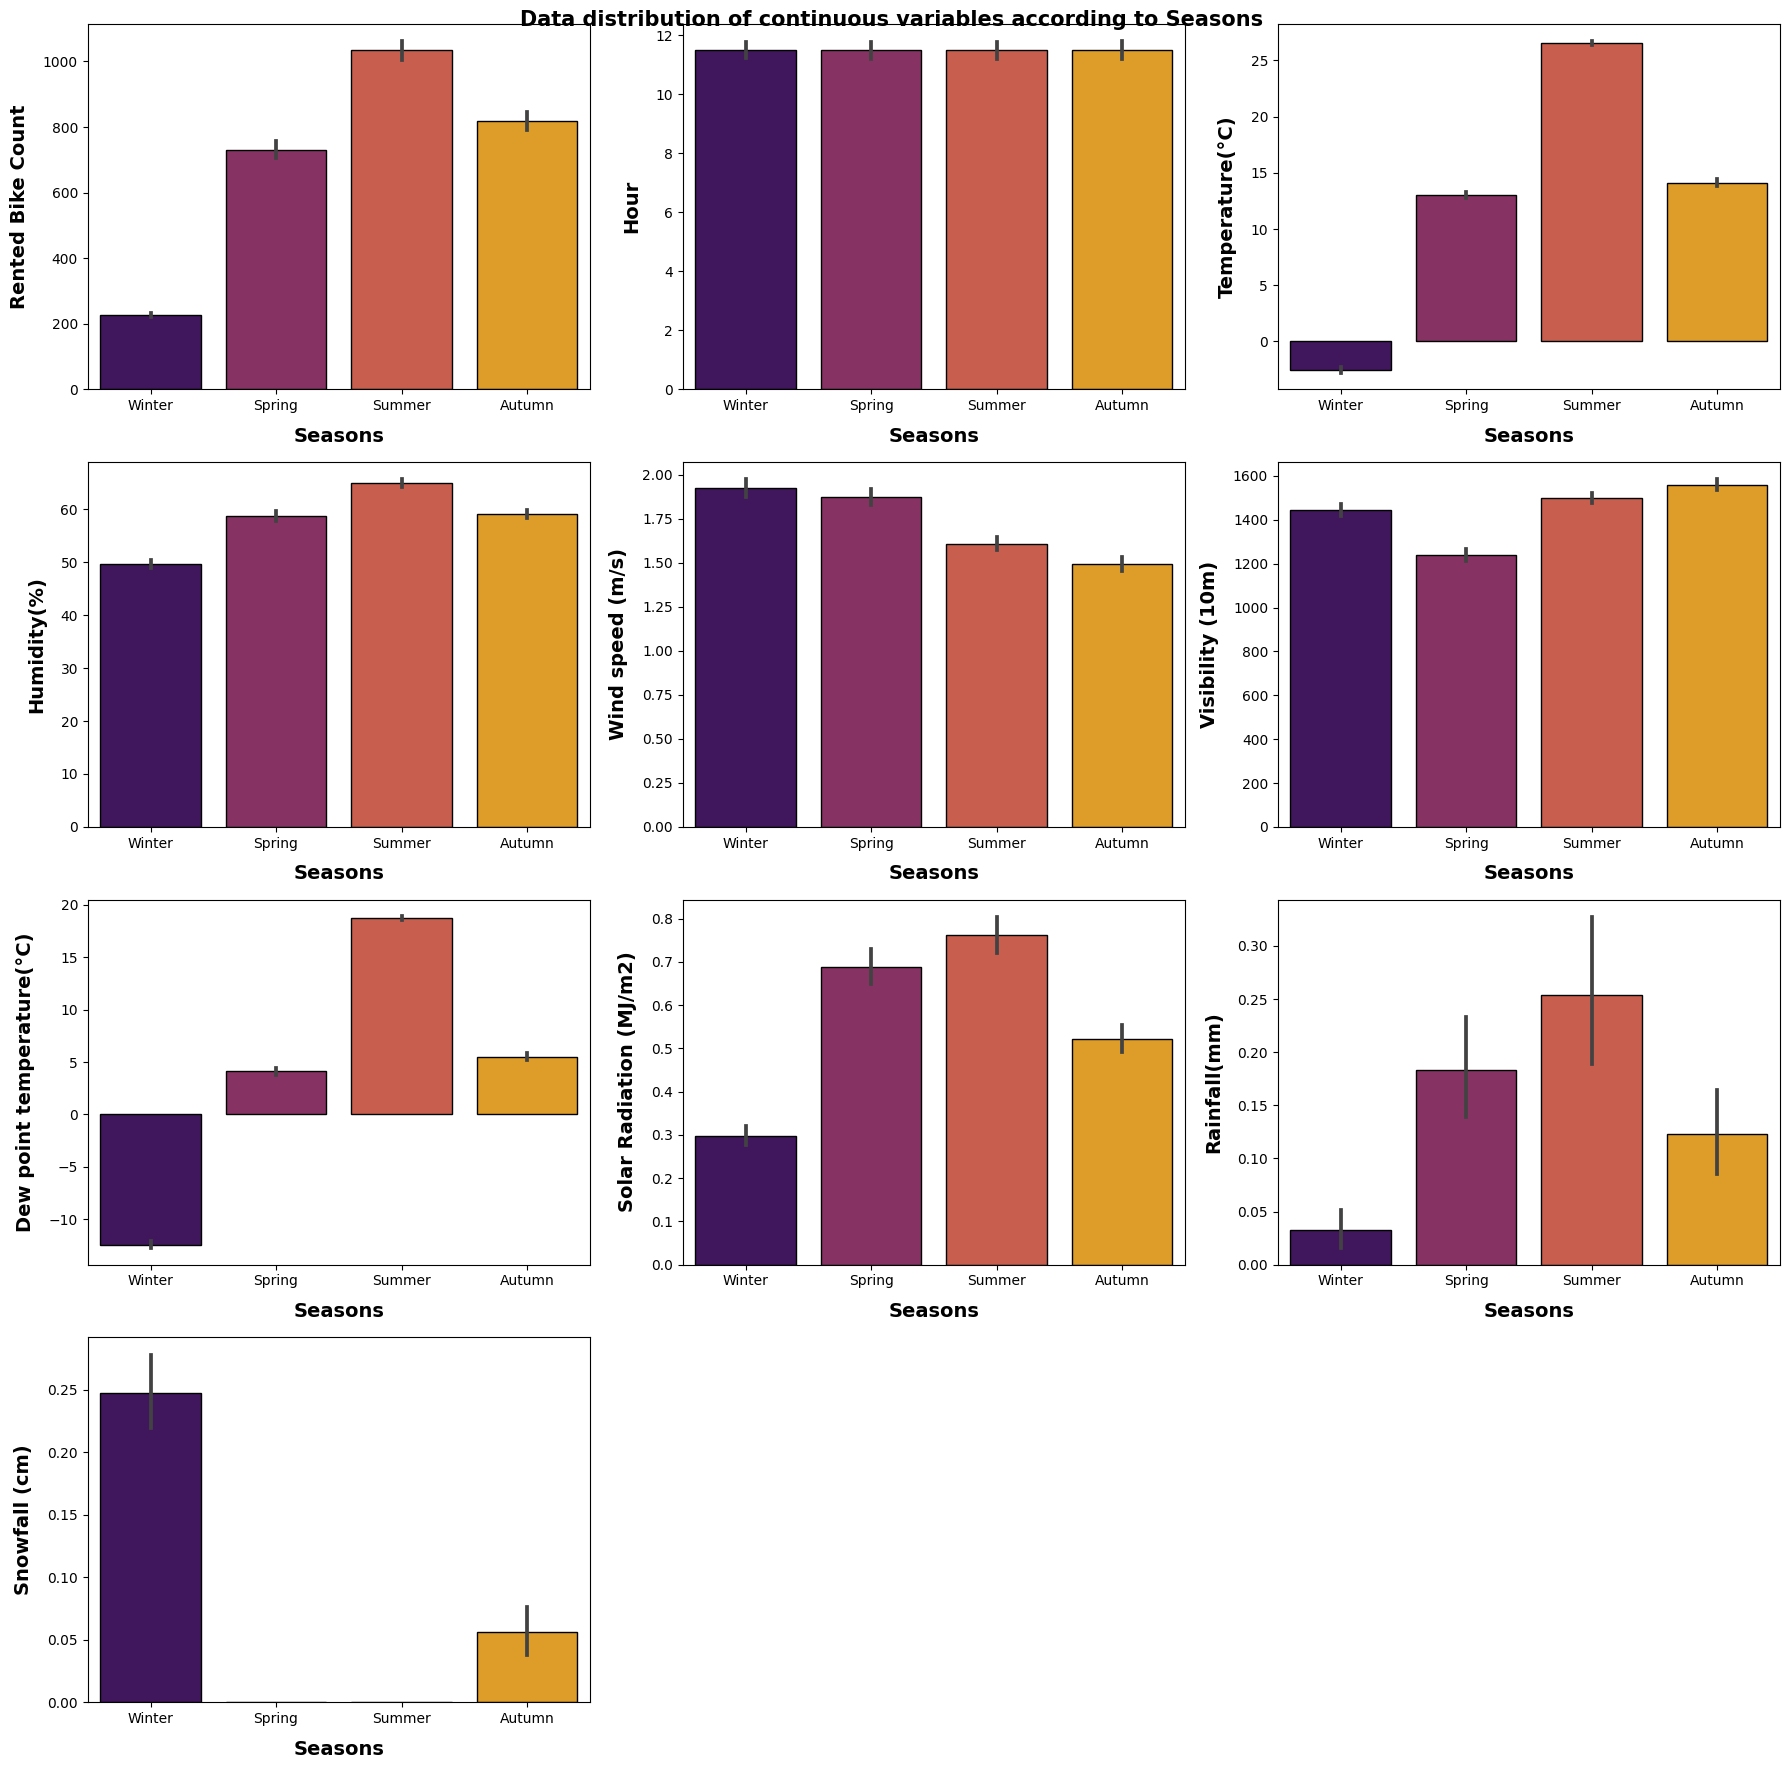

In [ ]:
# Plot Data ditribution of contunous variable according to hour
plt.figure(figsize=(18, 18))
for i, col in enumerate(bike_demand.drop(columns=['ID']).select_dtypes(include=['float64','int']).columns):
    plt.rcParams['axes.facecolor'] = 'White'
    ax = plt.subplot(4,3, i+1)
    ax.set_xlabel('Hour', fontsize=14, labelpad=10, fontweight='bold')
    ax.set_ylabel(col, fontsize=14, labelpad=10, fontweight='bold')
    sns.barplot(data=bike_demand,x='Seasons', y=col, ax=ax, edgecolor="Black", palette='inferno')
plt.suptitle('Data distribution of continuous variables according to Seasons ', fontsize=15, fontweight='bold')
plt.tight_layout()

<Figure size 1800x1800 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rented Bike Count')

<Axes: xlabel='Holiday', ylabel='Rented Bike Count'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Hour')

<Axes: xlabel='Holiday', ylabel='Hour'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Temperature(°C)')

<Axes: xlabel='Holiday', ylabel='Temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Humidity(%)')

<Axes: xlabel='Holiday', ylabel='Humidity(%)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Wind speed (m/s)')

<Axes: xlabel='Holiday', ylabel='Wind speed (m/s)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Visibility (10m)')

<Axes: xlabel='Holiday', ylabel='Visibility (10m)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Dew point temperature(°C)')

<Axes: xlabel='Holiday', ylabel='Dew point temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Solar Radiation (MJ/m2)')

<Axes: xlabel='Holiday', ylabel='Solar Radiation (MJ/m2)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rainfall(mm)')

<Axes: xlabel='Holiday', ylabel='Rainfall(mm)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Snowfall (cm)')

<Axes: xlabel='Holiday', ylabel='Snowfall (cm)'>

Text(0.5, 0.98, 'Data distribution of continuous variables according to Holiday ')

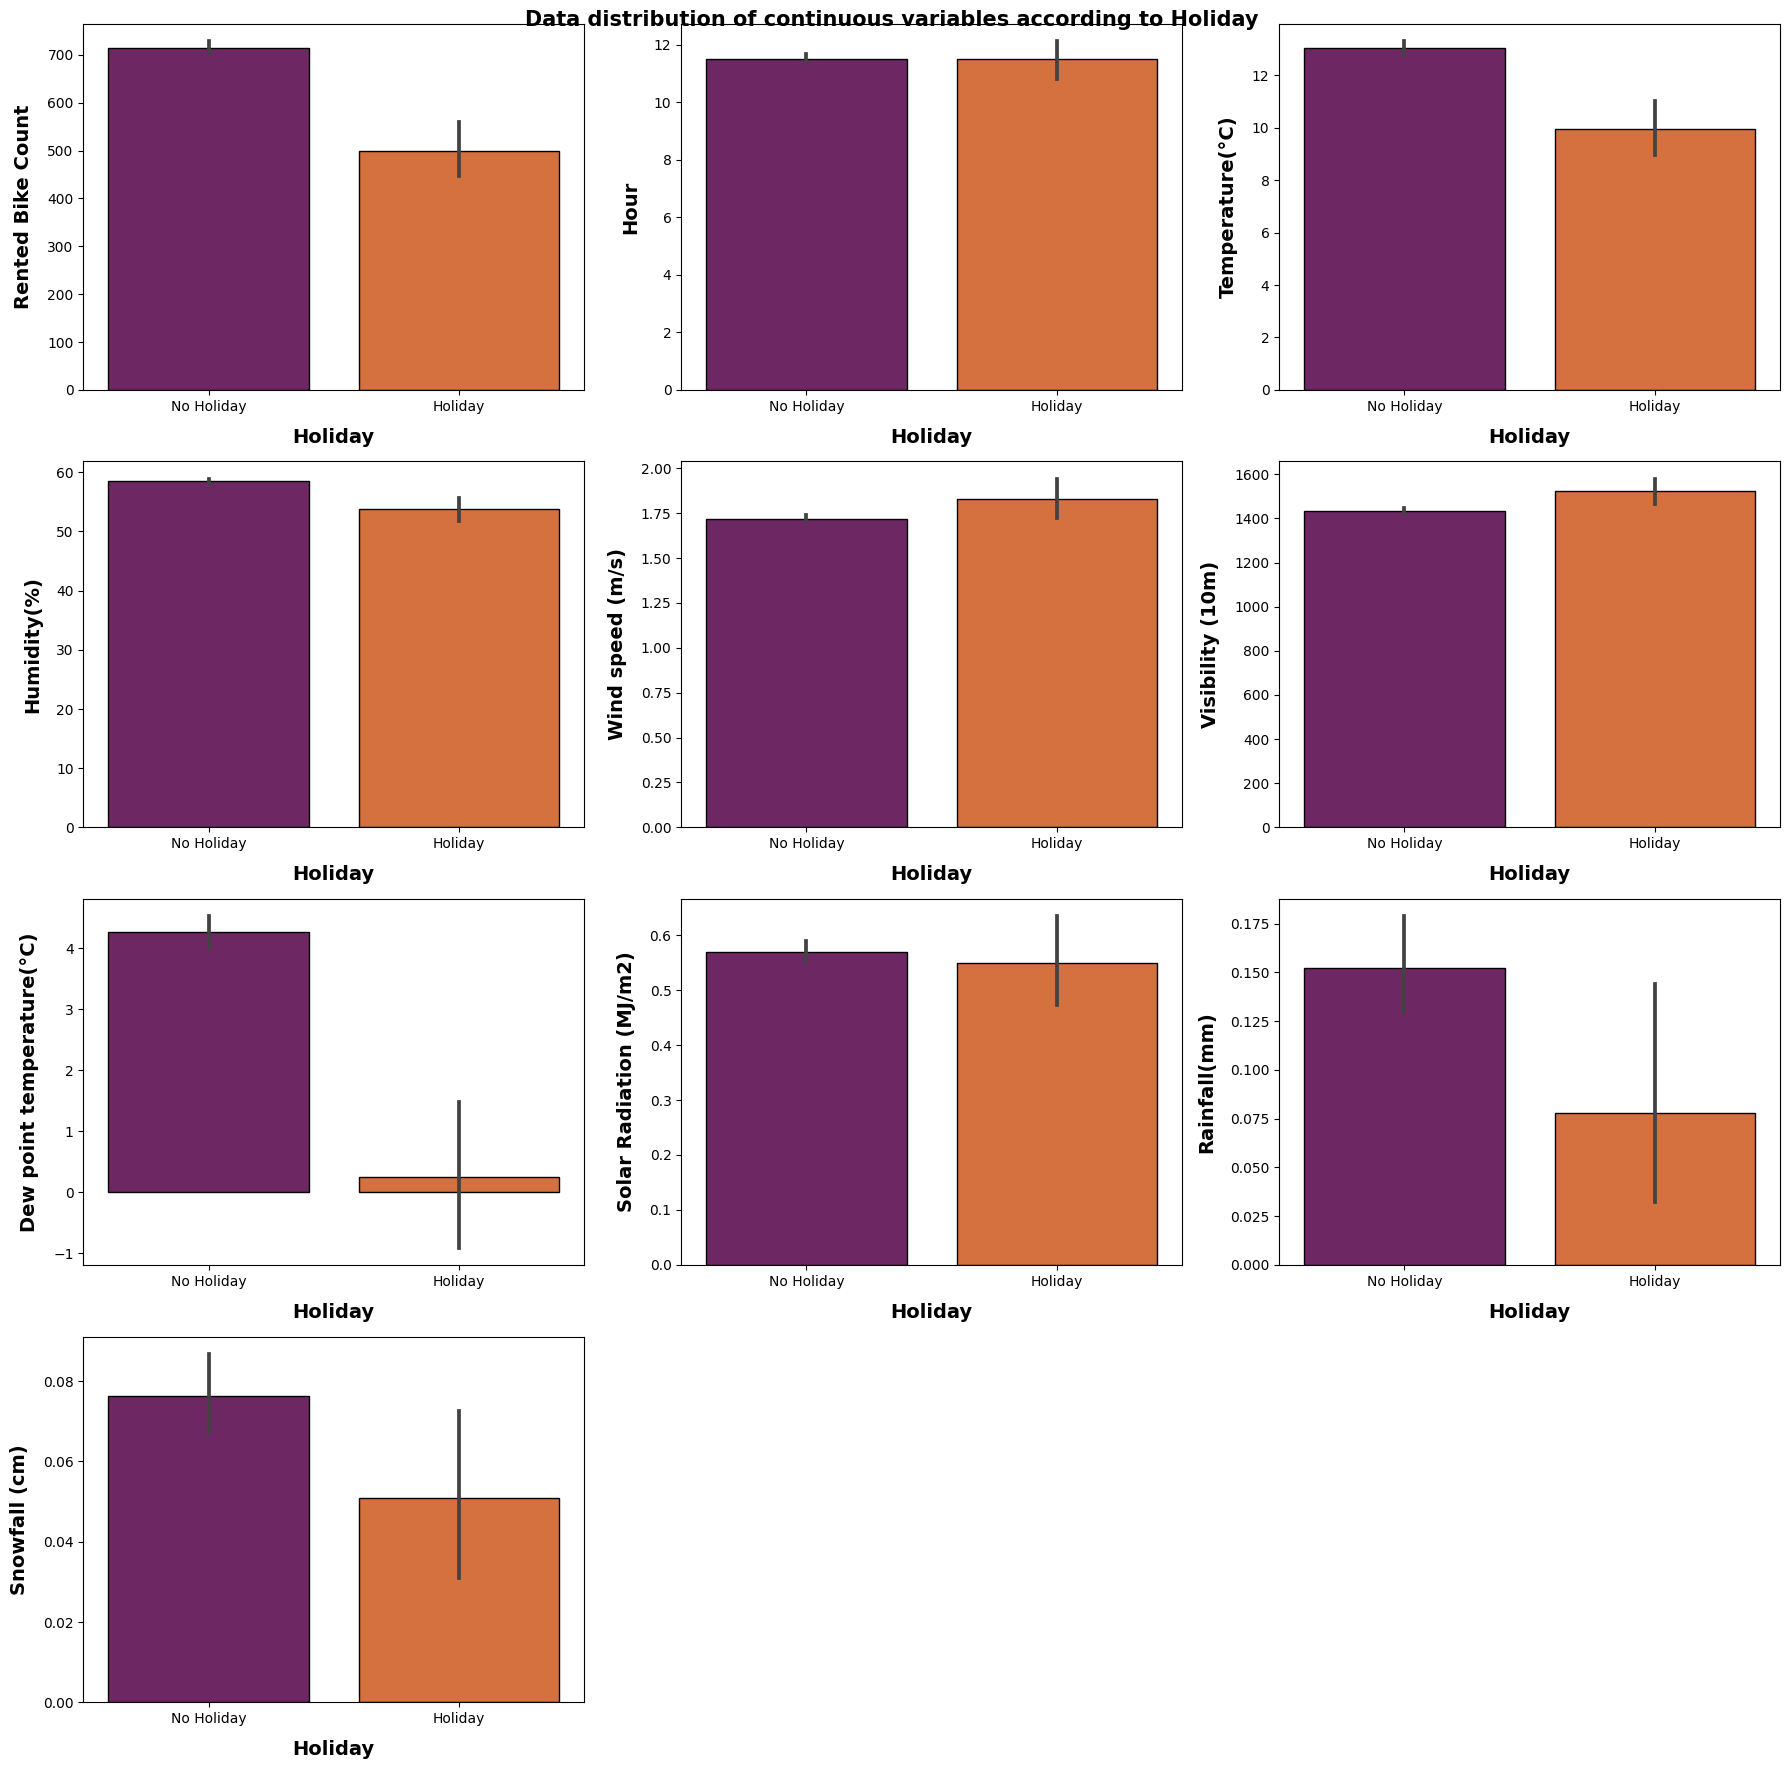

In [ ]:

# Plot Data ditribution of contunous variable according to hour
plt.figure(figsize=(18, 18))
for i, col in enumerate(bike_demand.drop(columns=['ID']).select_dtypes(include=['float64','int']).columns):
    plt.rcParams['axes.facecolor'] = 'White'
    ax = plt.subplot(4,3, i+1)
    ax.set_xlabel('Hour', fontsize=14, labelpad=10, fontweight='bold')
    ax.set_ylabel(col, fontsize=14, labelpad=10, fontweight='bold')
    sns.barplot(data=bike_demand,x='Holiday', y=col, ax=ax, edgecolor="Black", palette='inferno')
plt.suptitle('Data distribution of continuous variables according to Holiday ', fontsize=15, fontweight='bold')
plt.tight_layout()

<Figure size 1800x1800 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rented Bike Count')

<Axes: xlabel='Functioning Day', ylabel='Rented Bike Count'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Hour')

<Axes: xlabel='Functioning Day', ylabel='Hour'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Temperature(°C)')

<Axes: xlabel='Functioning Day', ylabel='Temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Humidity(%)')

<Axes: xlabel='Functioning Day', ylabel='Humidity(%)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Wind speed (m/s)')

<Axes: xlabel='Functioning Day', ylabel='Wind speed (m/s)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Visibility (10m)')

<Axes: xlabel='Functioning Day', ylabel='Visibility (10m)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Dew point temperature(°C)')

<Axes: xlabel='Functioning Day', ylabel='Dew point temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Solar Radiation (MJ/m2)')

<Axes: xlabel='Functioning Day', ylabel='Solar Radiation (MJ/m2)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rainfall(mm)')

<Axes: xlabel='Functioning Day', ylabel='Rainfall(mm)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Snowfall (cm)')

<Axes: xlabel='Functioning Day', ylabel='Snowfall (cm)'>

Text(0.5, 0.98, 'Data distribution of continuous variables according to Hour ')

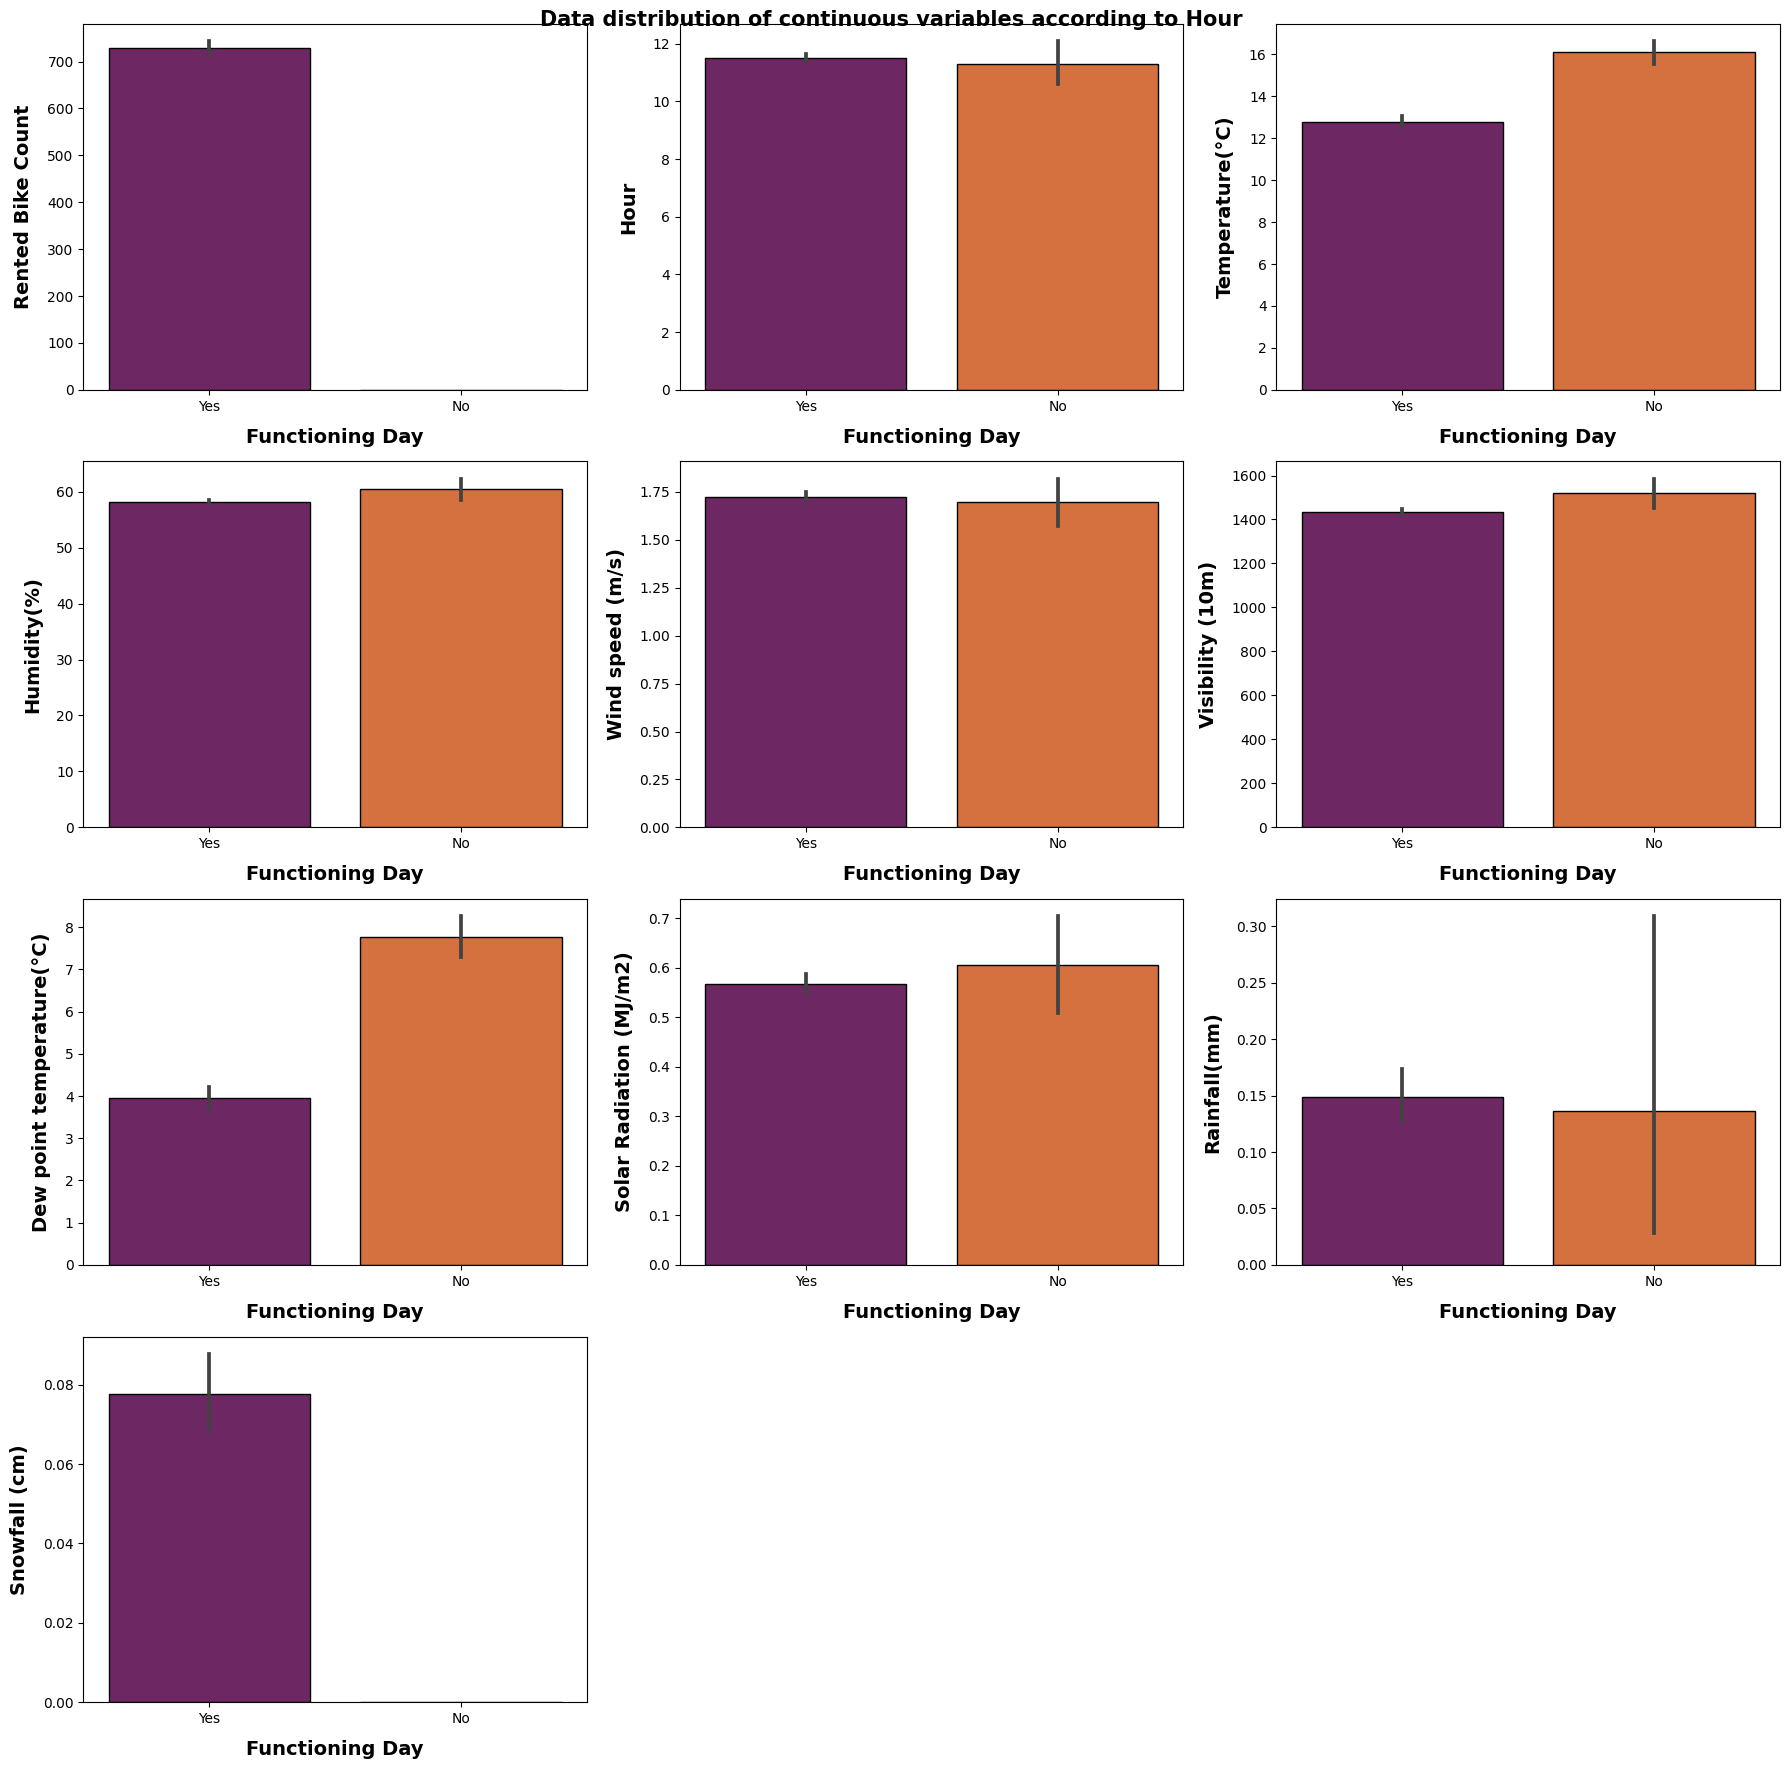

In [ ]:
# Plot Data ditribution of contunous variable according to hour
plt.figure(figsize=(18, 18))
for i, col in enumerate(bike_demand.drop(columns=['ID']).select_dtypes(include=['float64','int']).columns):
    plt.rcParams['axes.facecolor'] = 'White'
    ax = plt.subplot(4,3, i+1)
    ax.set_xlabel('Hour', fontsize=14, labelpad=10, fontweight='bold')
    ax.set_ylabel(col, fontsize=14, labelpad=10, fontweight='bold')
    sns.barplot(data=bike_demand,x='Functioning Day', y=col, ax=ax, edgecolor="Black", palette='inferno')
plt.suptitle('Data distribution of continuous variables according to Hour ', fontsize=15, fontweight='bold')
plt.tight_layout()

###***2.4 Statistical description and values of numerical columns***

In [ ]:
# Check col of Datetime dtype
bike_demand['Date'].value_counts().sort_values()
bike_demand['Date'].value_counts().value_counts()
bike_demand['Hour'].value_counts()

2017-01-12    24
2017-05-12    24
2017-06-12    24
2017-07-12    24
2017-08-12    24
              ..
2018-11-29    24
2018-10-11    24
2018-03-09    24
2018-07-11    24
2018-11-30    24
Name: Date, Length: 365, dtype: int64

24    365
Name: Date, dtype: int64

0     365
1     365
22    365
21    365
20    365
19    365
18    365
17    365
16    365
15    365
14    365
13    365
12    365
11    365
10    365
9     365
8     365
7     365
6     365
5     365
4     365
3     365
2     365
23    365
Name: Hour, dtype: int64

>*ThIs output shows that this dataset is recorded within 365 days from 2017-1-12 to 2018-30-11. and each day was recorded in 24 times correspoding to 24 hours each day.*

>*At this point, Hour can not be numerical dtypes, It shoulbe categorical dtypes*

<Figure size 1800x1800 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rented Bike Count')

<Axes: xlabel='Hour', ylabel='Rented Bike Count'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Temperature(°C)')

<Axes: xlabel='Hour', ylabel='Temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Humidity(%)')

<Axes: xlabel='Hour', ylabel='Humidity(%)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Wind speed (m/s)')

<Axes: xlabel='Hour', ylabel='Wind speed (m/s)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Visibility (10m)')

<Axes: xlabel='Hour', ylabel='Visibility (10m)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Dew point temperature(°C)')

<Axes: xlabel='Hour', ylabel='Dew point temperature(°C)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Solar Radiation (MJ/m2)')

<Axes: xlabel='Hour', ylabel='Solar Radiation (MJ/m2)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Rainfall(mm)')

<Axes: xlabel='Hour', ylabel='Rainfall(mm)'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Snowfall (cm)')

<Axes: xlabel='Hour', ylabel='Snowfall (cm)'>

Text(0.5, 0.98, 'Data distribution of continuous variables according to Hour ')

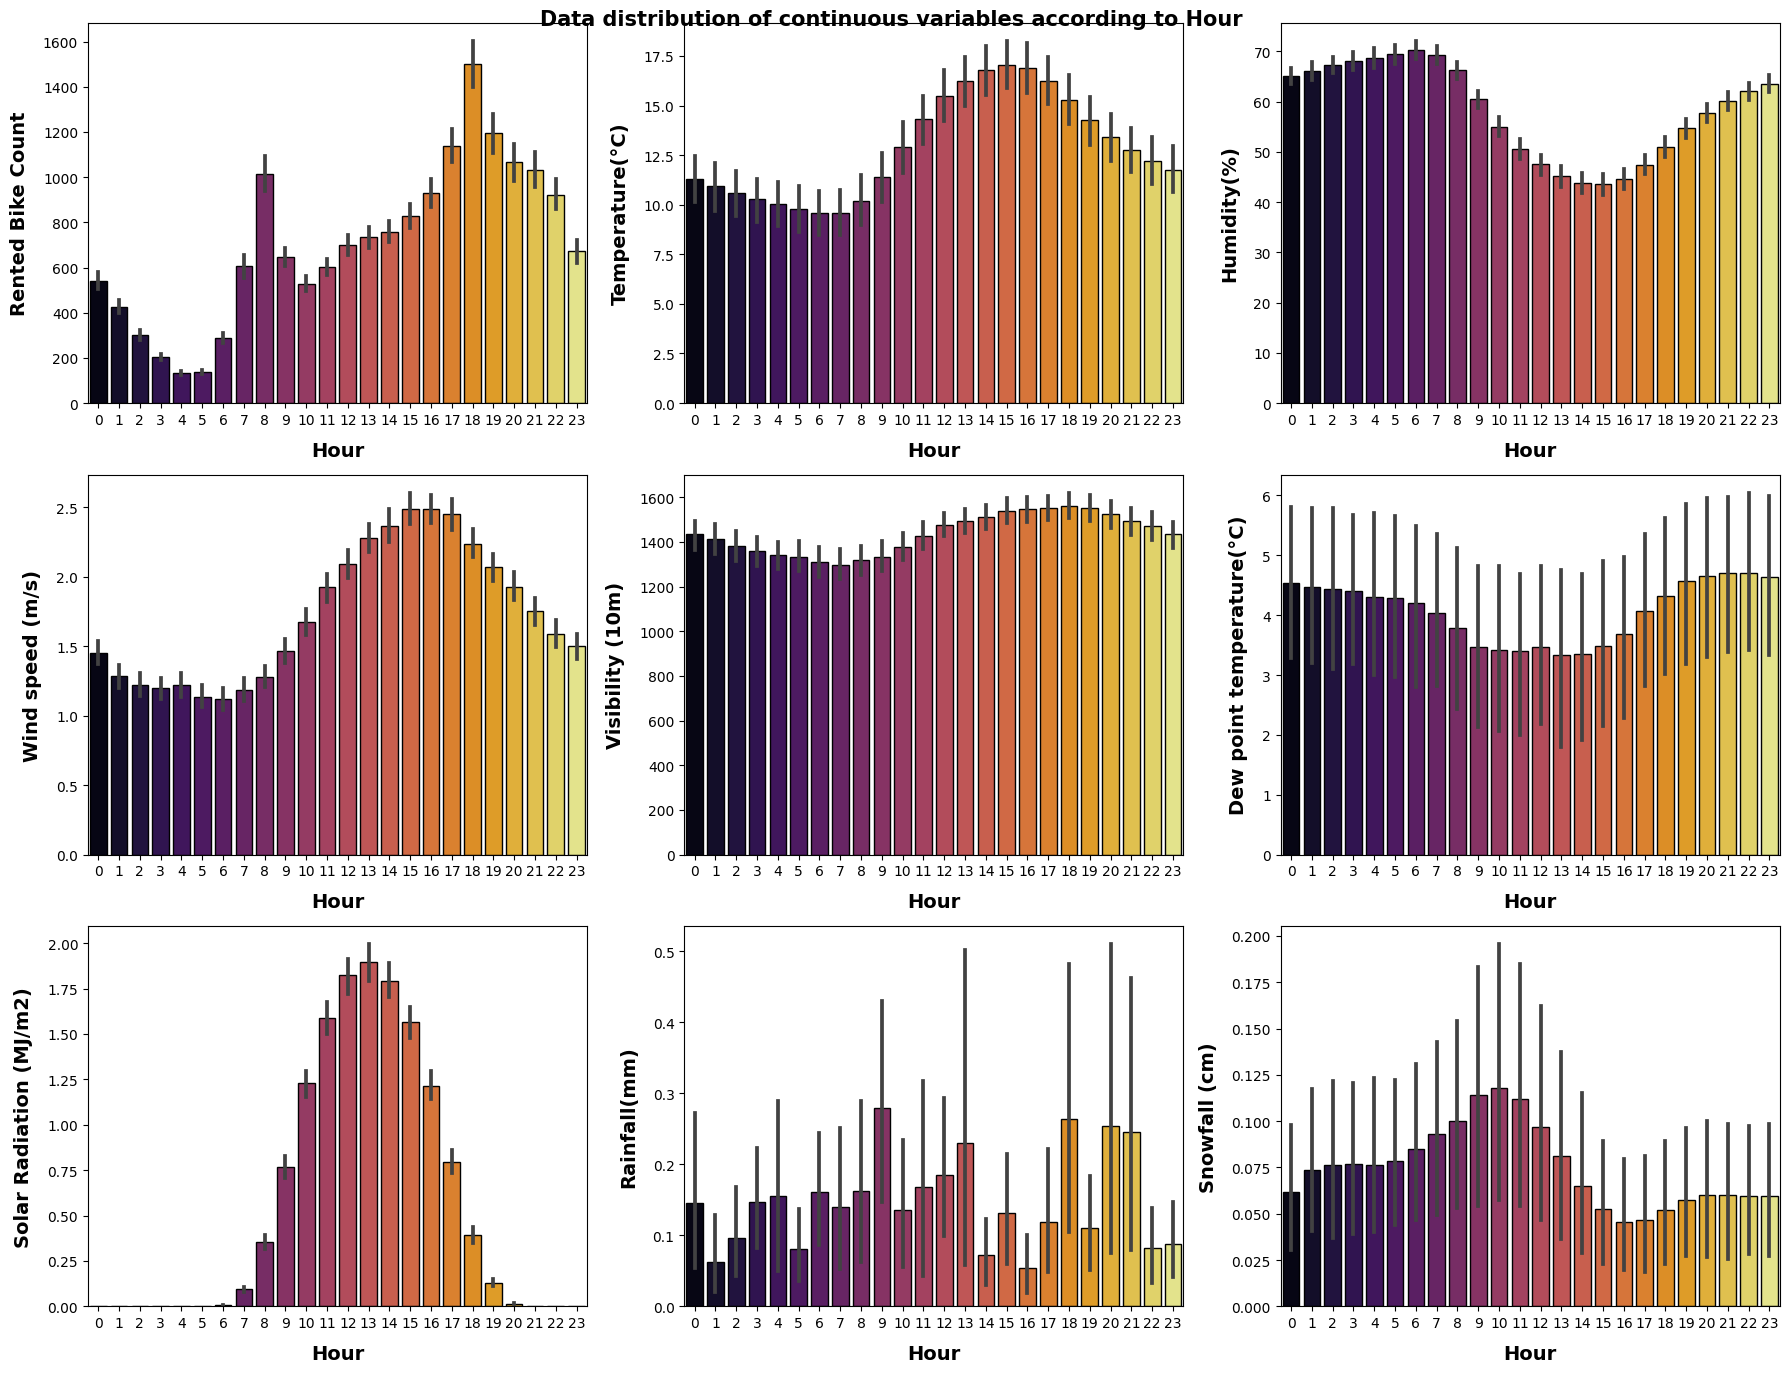

In [ ]:
# Transform "Hour" dtypes and describe numerical values
bike_demand['Hour'] = bike_demand['Hour'].astype('object')

# Plot Data ditribution of contunous variable according to hour
plt.figure(figsize=(18, 18))
for i, col in enumerate(bike_demand.drop(columns=['ID']).select_dtypes(include=['float64','int']).columns):
    plt.rcParams['axes.facecolor'] = 'White'
    ax = plt.subplot(4,3, i+1)
    ax.set_xlabel('Hour', fontsize=14, labelpad=10, fontweight='bold')
    ax.set_ylabel(col, fontsize=14, labelpad=10, fontweight='bold')
    sns.barplot(data=bike_demand,x='Hour', y=col, ax=ax, edgecolor="Black", palette='inferno')
plt.suptitle('Data distribution of continuous variables according to Hour ', fontsize=15, fontweight='bold')
plt.tight_layout()


 >*The above chart shows that the mean and range of max min values of each feature versus hour.*

 >>*The number of rented bikes is higher at peak hours 8h and 18h than the others.*

 >>*Data Distribution of other continous variables versus hour is reasonable:*

 >>>*Example: Solar radiation is so high at lunch.*

In [ ]:
# Describe numerical variables
bike_demand.drop(columns='ID').describe().style.background_gradient()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


>*Not too much values are out of its range*

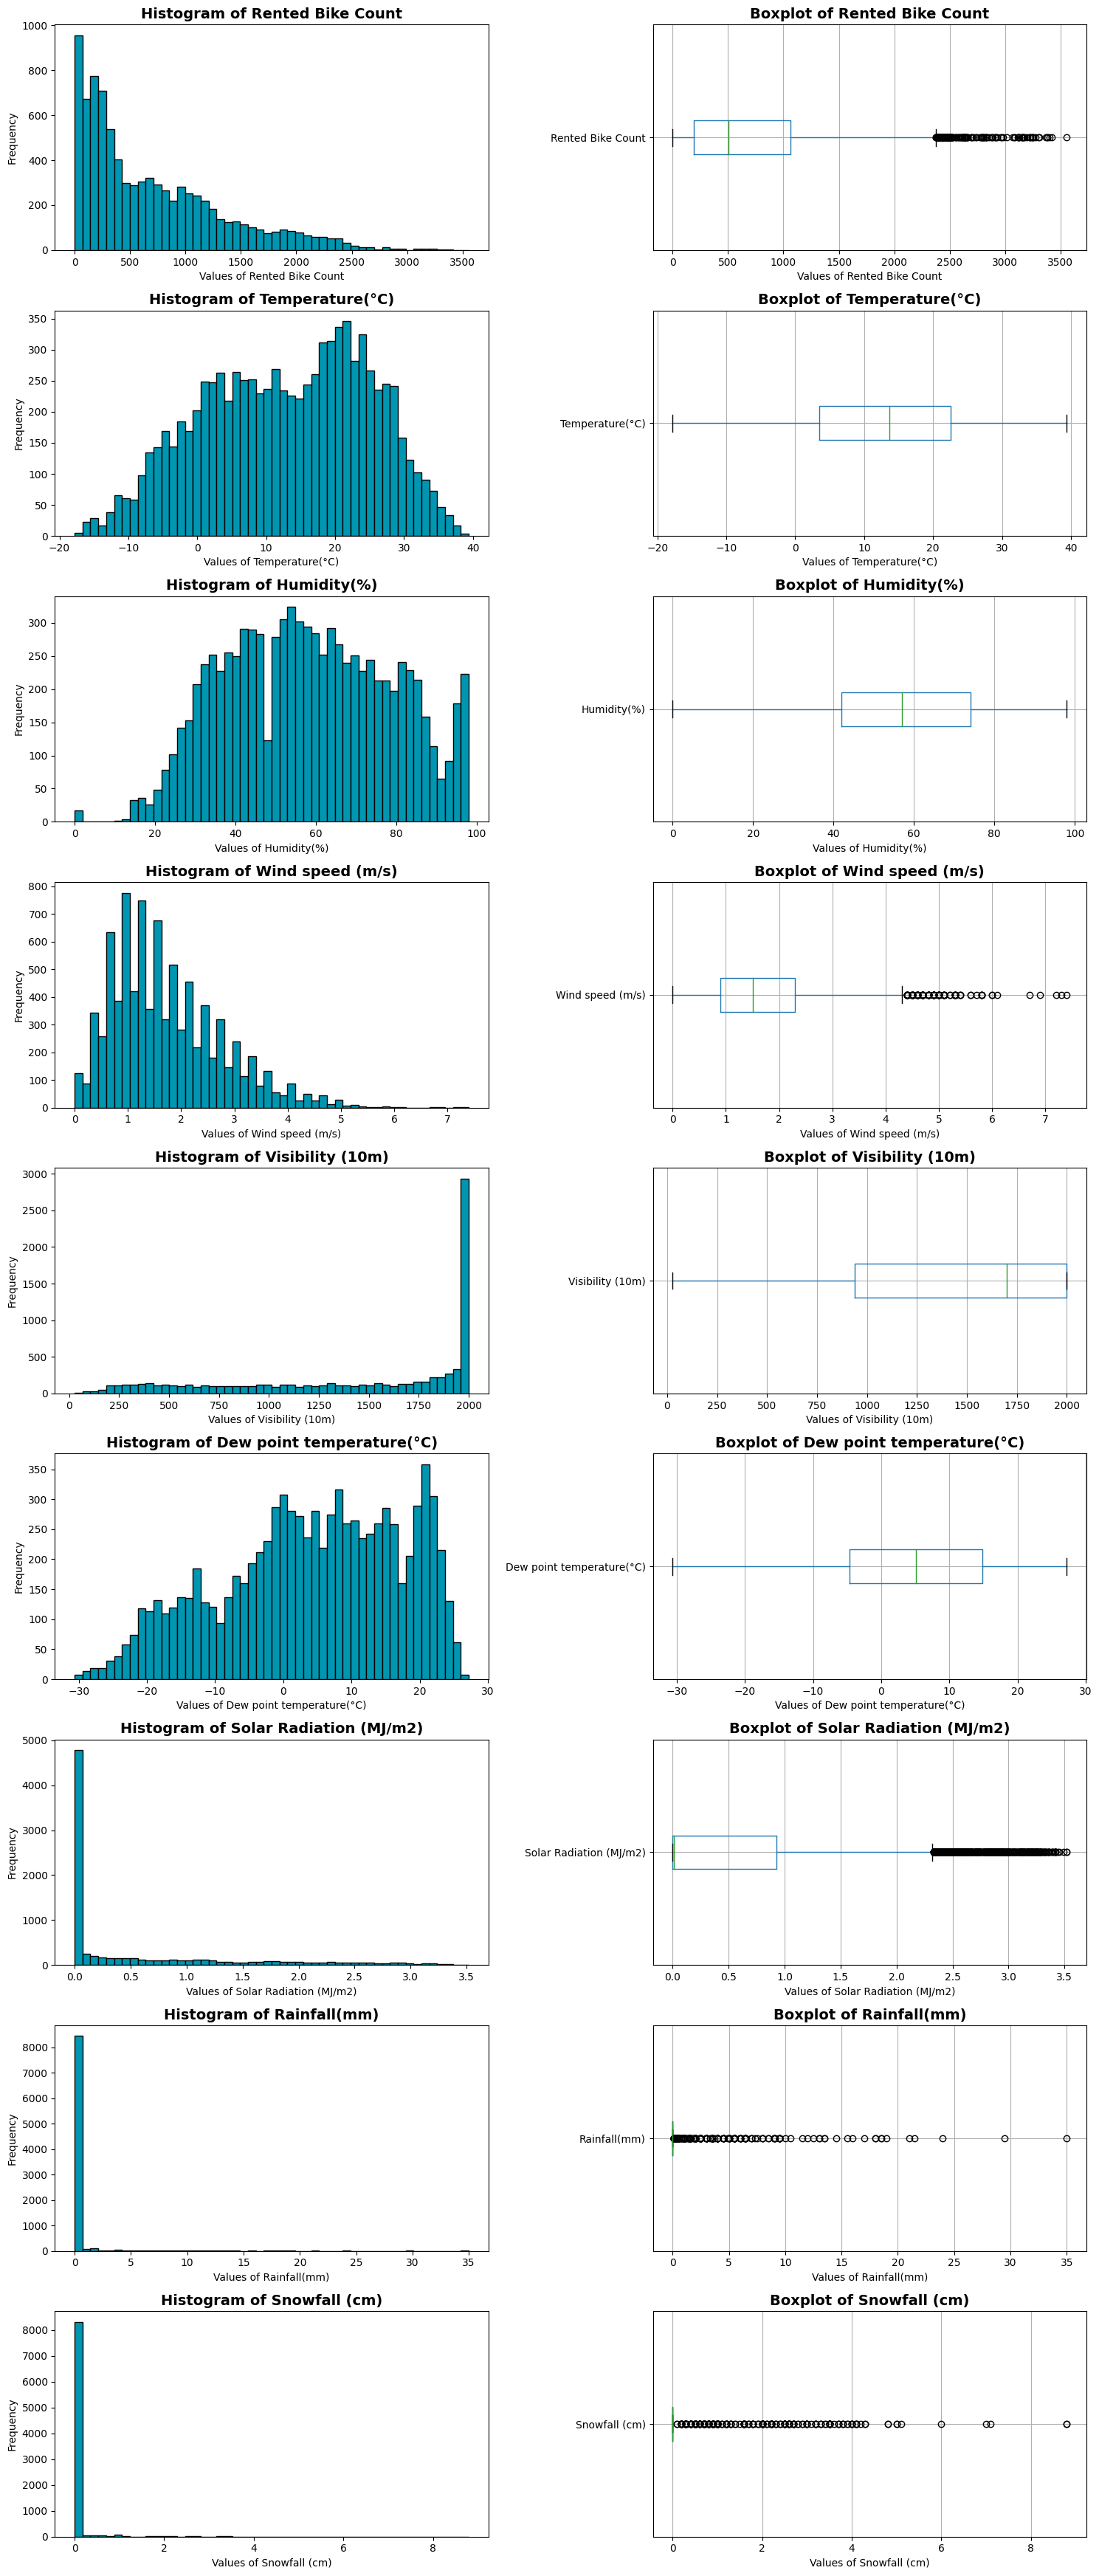

In [ ]:

# Create subplots
fig, axs = plt.subplots(9, 2, figsize=(15, 5*7))

# Loop over each column and plot a histogram and boxplot                                                                                             
for i, column in enumerate(bike_demand.drop(columns='ID').select_dtypes(['int64','float64']).columns):
    # Histogram
    axs[i, 0].hist(bike_demand[column], bins=50, color='#0096b1', edgecolor='Black')
    axs[i, 0].set_title(f"Histogram of {column}", fontsize=14, fontweight='bold')
    axs[i, 0].set_xlabel(f"Values of {column}")
    axs[i, 0].set_ylabel("Frequency")
    
    # Boxplot
    bike_demand[column].to_frame().boxplot(ax=axs[i, 1], vert=False)
    axs[i, 1].set_title(f"Boxplot of {column}", fontsize=14, fontweight='bold')
    axs[i, 1].set_xlabel(f"Values of {column}")
    axs[i, 1].set_ylabel("");
    
# Adjust subplot spacing
fig.tight_layout()
plt.show();

<Figure size 1200x1200 with 0 Axes>

Text(0.5, 0, 'Rented Bike Count')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Rented Bike Count', ylabel='Count'>

Text(0.5, 0, 'Temperature(°C)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Temperature(°C)', ylabel='Count'>

Text(0.5, 0, 'Humidity(%)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Humidity(%)', ylabel='Count'>

Text(0.5, 0, 'Wind speed (m/s)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Wind speed (m/s)', ylabel='Count'>

Text(0.5, 0, 'Visibility (10m)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Visibility (10m)', ylabel='Count'>

Text(0.5, 0, 'Dew point temperature(°C)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Dew point temperature(°C)', ylabel='Count'>

Text(0.5, 0, 'Solar Radiation (MJ/m2)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Solar Radiation (MJ/m2)', ylabel='Count'>

Text(0.5, 0, 'Rainfall(mm)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Rainfall(mm)', ylabel='Count'>

Text(0.5, 0, 'Snowfall (cm)')

<ipython-input-15-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Snowfall (cm)', ylabel='Count'>

Text(0.5, 0.98, 'Data distribution of continuous variables')

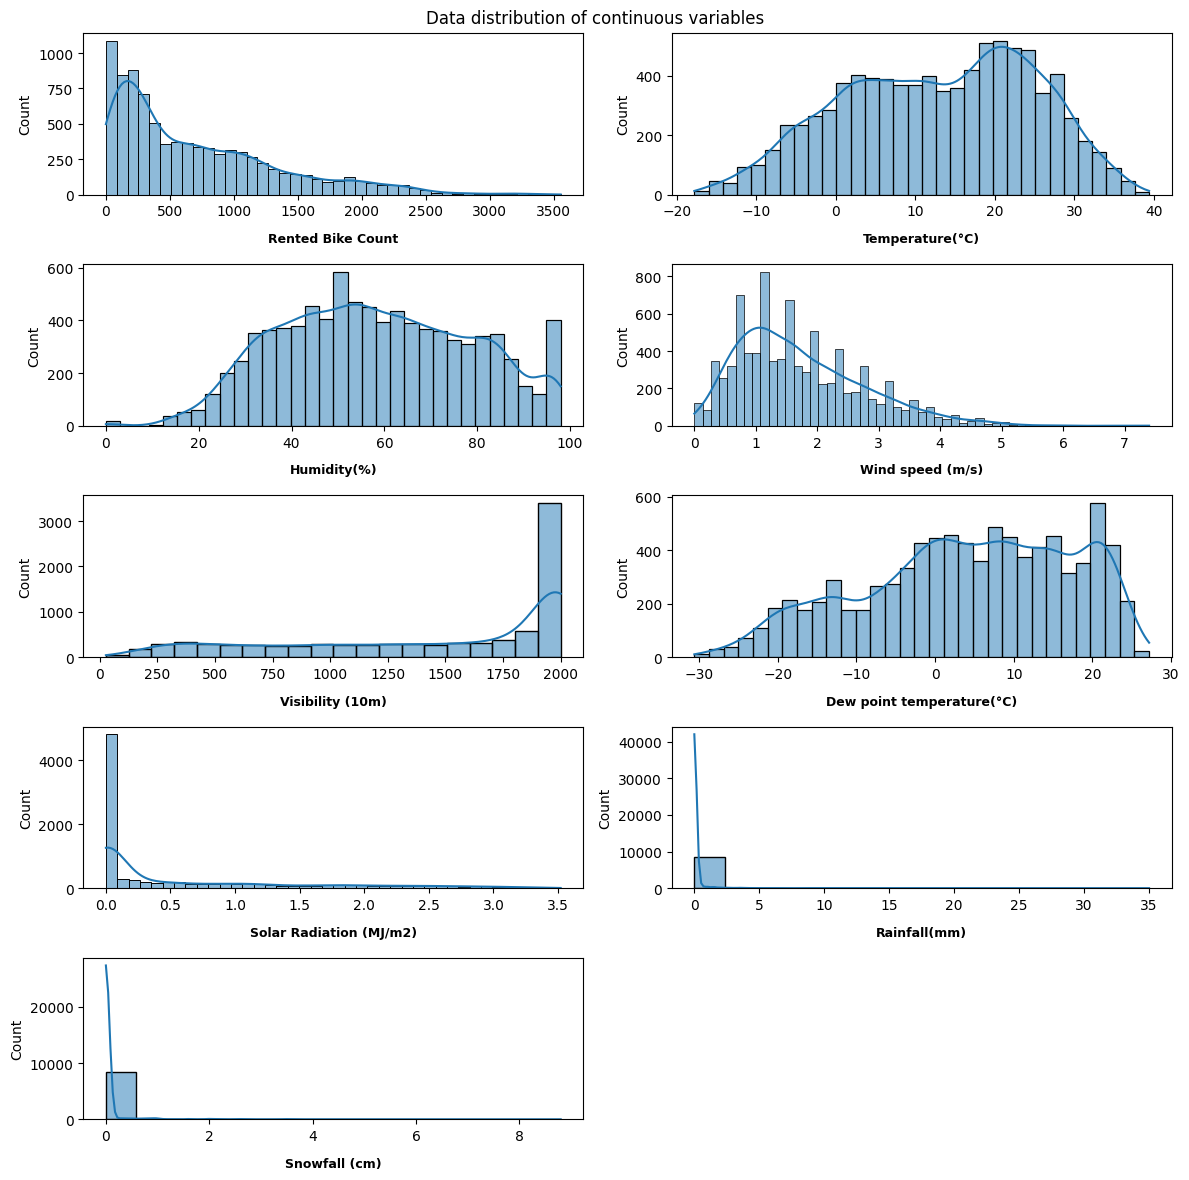

In [ ]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(bike_demand.drop(columns='ID').select_dtypes(include=['float64','int64']).columns):
    plt.rcParams['axes.facecolor'] = 'White'
    ax = plt.subplot(5,2, i+1)
    ax.set_xlabel(col, fontsize=9, labelpad=10, fontweight='bold')
    sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()

>*The skewness of histograms is both negetive and positive*

In [ ]:
# Apply Power Transforms to transform distribution of numerical variables to be less skewness and may have a Gaussian-like distribution (e.g. nearly Gaussian but with outliers or a skew)
from sklearn.preprocessing import PowerTransformer
#selecting variables that have data types float and int.
var = list(bike_demand.drop(columns='ID').select_dtypes(include=['float64','int64']).columns)
sc_X=PowerTransformer(method = 'yeo-johnson')
bike_demand[var]=sc_X.fit_transform(bike_demand[var])

In [ ]:
bike_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         8760 non-null   int64         
 1   Date                       8760 non-null   datetime64[ns]
 2   Rented Bike Count          8760 non-null   float64       
 3   Hour                       8760 non-null   object        
 4   Temperature(°C)            8760 non-null   float64       
 5   Humidity(%)                8760 non-null   float64       
 6   Wind speed (m/s)           8760 non-null   float64       
 7   Visibility (10m)           8760 non-null   float64       
 8   Dew point temperature(°C)  8760 non-null   float64       
 9   Solar Radiation (MJ/m2)    8760 non-null   float64       
 10  Rainfall(mm)               8760 non-null   float64       
 11  Snowfall (cm)              8760 non-null   float64       
 12  Season

<Figure size 1200x1200 with 0 Axes>

Text(0.5, 0, 'Rented Bike Count')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Rented Bike Count', ylabel='Count'>

Text(0.5, 0, 'Temperature(°C)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Temperature(°C)', ylabel='Count'>

Text(0.5, 0, 'Humidity(%)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Humidity(%)', ylabel='Count'>

Text(0.5, 0, 'Wind speed (m/s)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Wind speed (m/s)', ylabel='Count'>

Text(0.5, 0, 'Visibility (10m)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Visibility (10m)', ylabel='Count'>

Text(0.5, 0, 'Dew point temperature(°C)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Dew point temperature(°C)', ylabel='Count'>

Text(0.5, 0, 'Solar Radiation (MJ/m2)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Solar Radiation (MJ/m2)', ylabel='Count'>

Text(0.5, 0, 'Rainfall(mm)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Rainfall(mm)', ylabel='Count'>

Text(0.5, 0, 'Snowfall (cm)')

<ipython-input-18-b1f47e87e763>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')


<Axes: xlabel='Snowfall (cm)', ylabel='Count'>

Text(0.5, 0.98, 'Data distribution of continuous variables')

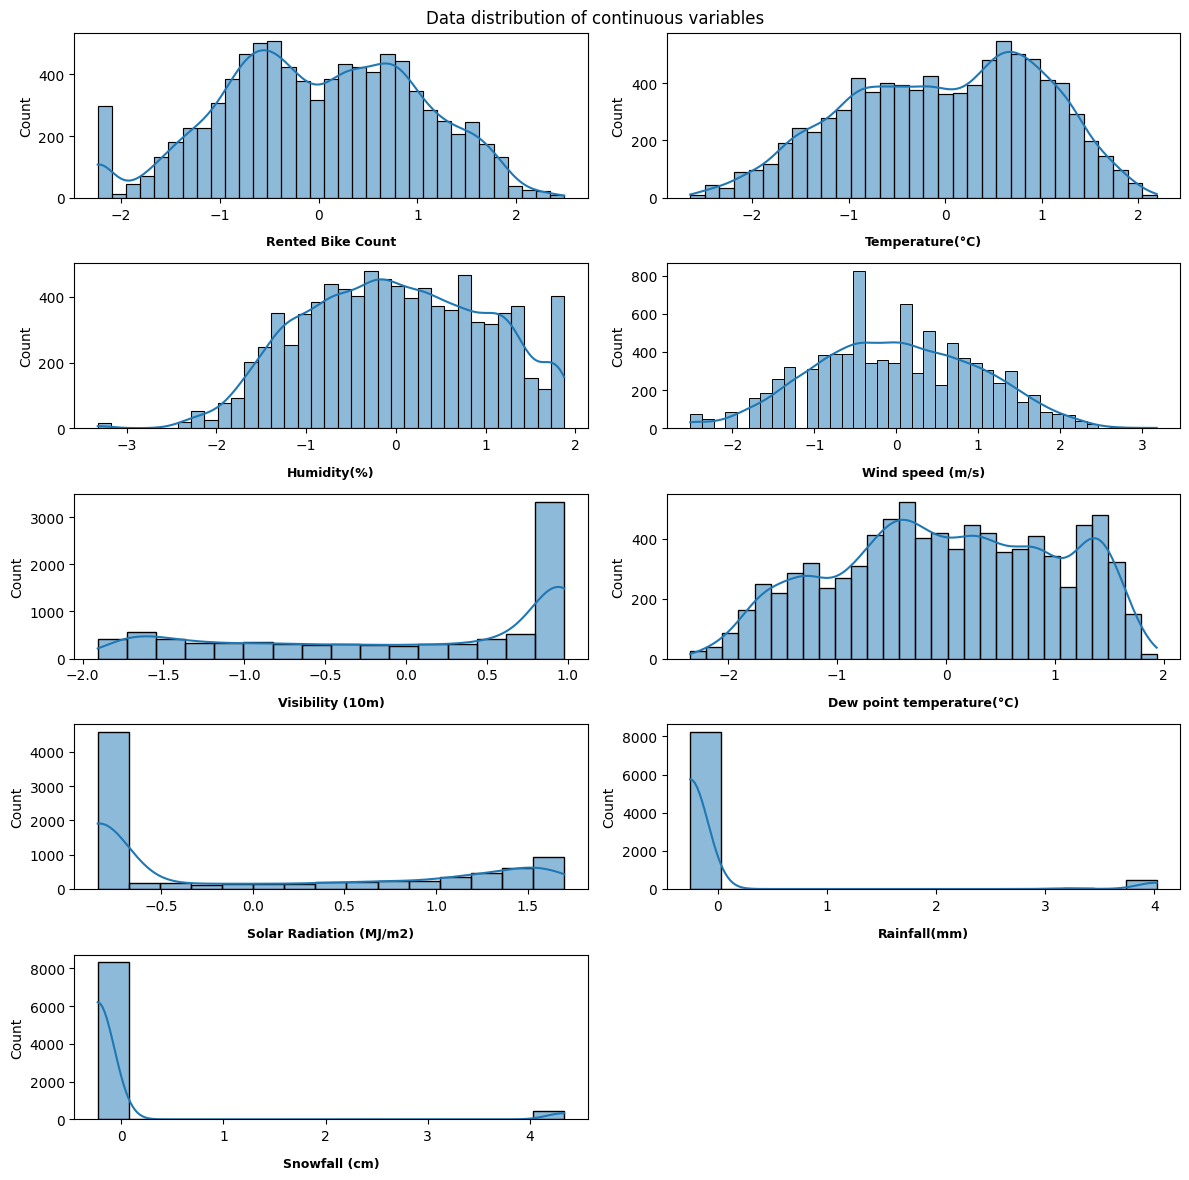

In [ ]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(bike_demand.drop(columns='ID').select_dtypes(include=['float64','int64']).columns):
    plt.rcParams['axes.facecolor'] = 'White'
    ax = plt.subplot(5,2, i+1)
    ax.set_xlabel(col, fontsize=9, labelpad=10, fontweight='bold')
    sns.histplot(data=bike_demand, x=col, ax=ax,kde=True, edgecolor="Black", palette='inferno')
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()

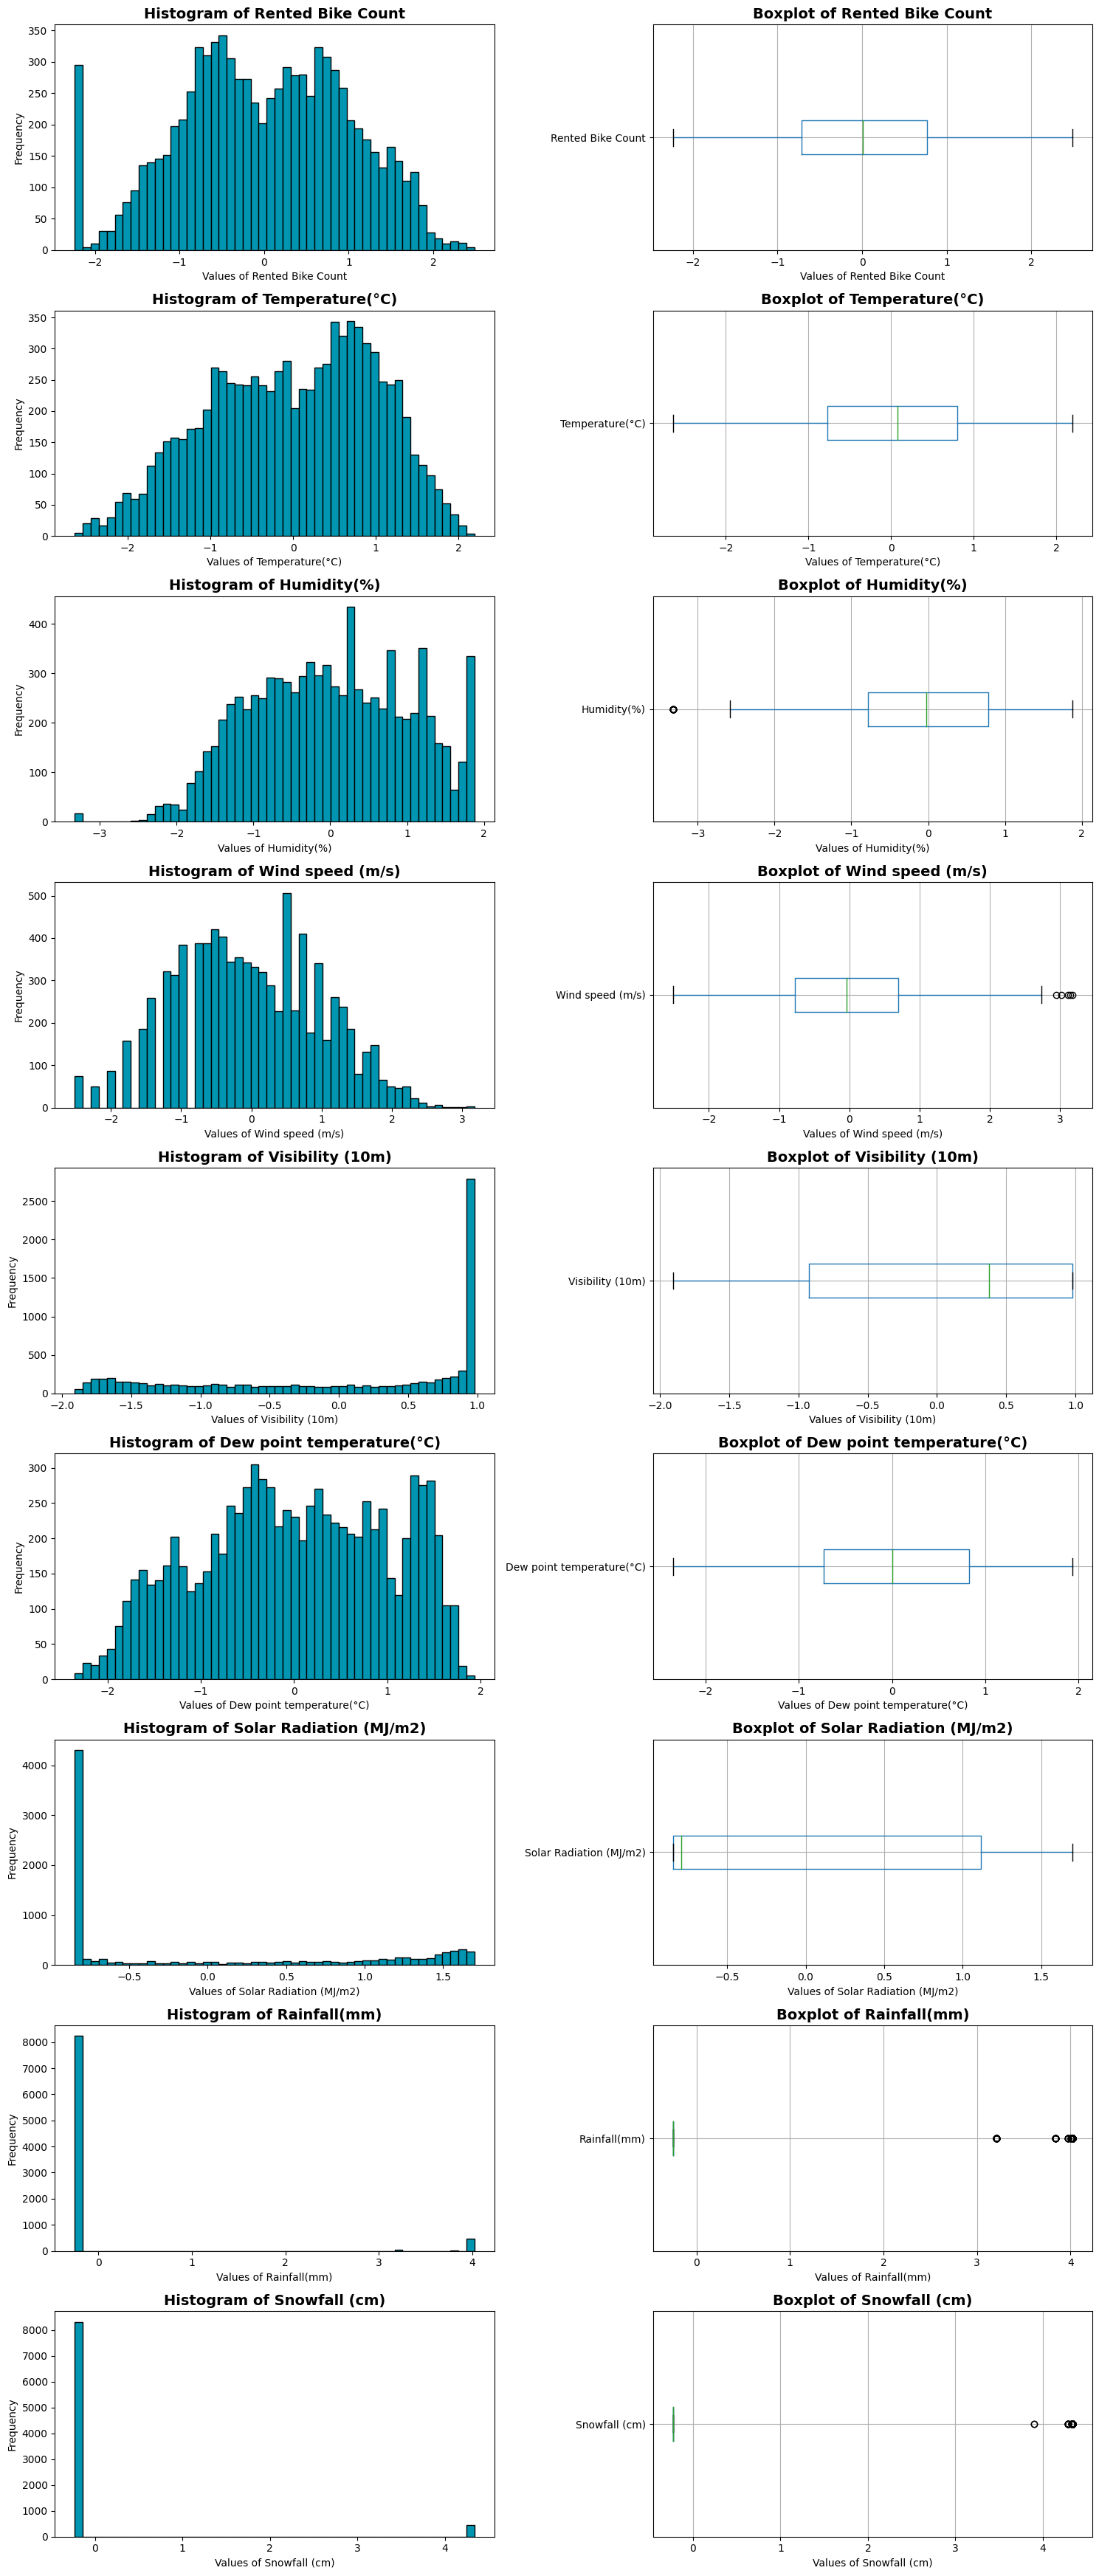

In [ ]:
# Create subplots
fig, axs = plt.subplots(9, 2, figsize=(15, 5*7))

# Loop over each column and plot a histogram and boxplot                                                                                             
for i, column in enumerate(bike_demand.drop(columns='ID').select_dtypes(['int64','float64']).columns):
    # Histogram
    axs[i, 0].hist(bike_demand[column], bins=50, color='#0096b1', edgecolor='Black')
    axs[i, 0].set_title(f"Histogram of {column}", fontsize=14, fontweight='bold')
    axs[i, 0].set_xlabel(f"Values of {column}")
    axs[i, 0].set_ylabel("Frequency")
    
    # Boxplot
    bike_demand[column].to_frame().boxplot(ax=axs[i, 1], vert=False)
    axs[i, 1].set_title(f"Boxplot of {column}", fontsize=14, fontweight='bold')
    axs[i, 1].set_xlabel(f"Values of {column}")
    axs[i, 1].set_ylabel("");
    
# Adjust subplot spacing
fig.tight_layout()
plt.show();

>*After applying Power Transform, distribution of numerical variable is less skewness, outliers are lost much.*

>*This leads to help machine learn better and give better performance.*

###*2.5 Check consistency of columns*

In [ ]:
Bike_date_holiday = bike_demand.groupby(['Date', 'Holiday']).size().reset_index(name='Count')
Bike_date_holiday_df = pd.DataFrame(Bike_date_holiday)
Bike_date_holiday_df['Count'].value_counts()
Bike_date_holiday_df

24    365
Name: Count, dtype: int64

,Date,Holiday,Count
0,2017-01-12,No Holiday,24
1,2017-02-12,No Holiday,24
2,2017-03-12,No Holiday,24
3,2017-04-12,No Holiday,24
4,2017-05-12,No Holiday,24
...,...,...,...
360,2018-12-07,No Holiday,24
361,2018-12-08,No Holiday,24
362,2018-12-09,No Holiday,24
363,2018-12-10,No Holiday,24


> *Date are consistent to Holiday, because  each combination of values in the Date and Holiday columns is unique, and each combination occurs 24 times (correspondence to 24 hours/day). This means that no date has both 2 values of "holiday" column.*

In [ ]:
Bike_date_func = bike_demand.groupby(['Date', 'Functioning Day']).size().reset_index(name='Count')
Bike_date_func_df = pd.DataFrame(Bike_date_func)
Bike_date_func_df['Count'].value_counts()
Bike_date_func_df

24    364
7       1
17      1
Name: Count, dtype: int64

,Date,Functioning Day,Count
0,2017-01-12,Yes,24
1,2017-02-12,Yes,24
2,2017-03-12,Yes,24
3,2017-04-12,Yes,24
4,2017-05-12,Yes,24
...,...,...,...
361,2018-12-07,Yes,24
362,2018-12-08,Yes,24
363,2018-12-09,Yes,24
364,2018-12-10,Yes,24


> *There is one date having 2 both values of functioning day. It's needed to check what that date is and replace that date.*

In [ ]:
# Check what date is both Functioning day and No Functioninf day
Bike_date_func_df.loc[Bike_date_func_df['Count'] < 24,:]
bike_demand.loc[bike_demand['Date'] == '2018-06-10',:][['Date','Hour', 'Functioning Day']]

,Date,Functioning Day,Count
186,2018-06-10,No,7
187,2018-06-10,Yes,17


,Date,Hour,Functioning Day
7416,2018-06-10,0,No
7417,2018-06-10,1,No
7418,2018-06-10,2,No
7419,2018-06-10,3,No
7420,2018-06-10,4,No
7421,2018-06-10,5,No
7422,2018-06-10,6,No
7423,2018-06-10,7,Yes
7424,2018-06-10,8,Yes
7425,2018-06-10,9,Yes


>*Value of 'Yes' accounts for more than Value of 'No'. Thus, it's clear to replace value of 'No' by 'Yes'*

In [ ]:
# Replace values for 'Functioning Day' col
bike_demand.loc[(bike_demand['Date'] == '2018-06-10') & (bike_demand['Functioning Day'] == 'No'), 'Functioning Day'] = 'Yes'
bike_demand.loc[bike_demand['Date'] == '2018-06-10',:][['Date','Hour', 'Functioning Day']]

,Date,Hour,Functioning Day
7416,2018-06-10,0,Yes
7417,2018-06-10,1,Yes
7418,2018-06-10,2,Yes
7419,2018-06-10,3,Yes
7420,2018-06-10,4,Yes
7421,2018-06-10,5,Yes
7422,2018-06-10,6,Yes
7423,2018-06-10,7,Yes
7424,2018-06-10,8,Yes
7425,2018-06-10,9,Yes


<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

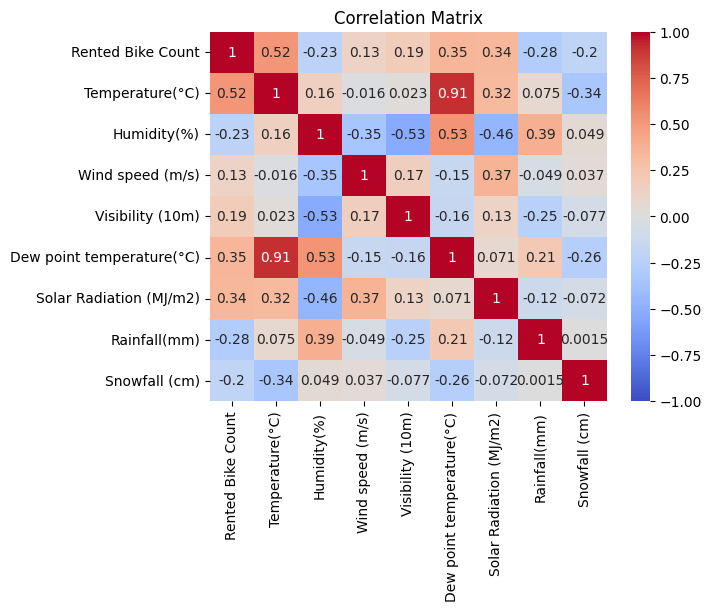

In [ ]:
# Compute the correlation matrix between the columns
corr_matrix = bike_demand.drop(columns='ID').select_dtypes(include=['int64','float64']).corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the title of the plot
plt.title('Correlation Matrix')

# Show the plot
plt.show()  


>*From above heatmap, it's easy to see the high correlation of "rented bkie count" and "Temperature". This means that The higher temperature, the higher rented bike count.*

>*The correlations among "Rainfall", "Snowfall" and "Rented Bike Count" show that "Rainfall" and "Snowfall" have week correlation "Rented Bike Count"*

>*Dew point temperature(°C) and temperature(°C) have strong possitive correlation*


###***2.6 Transform categorical data to numerical data***

In [ ]:
# Add column of the week based on "Date" column 
def add_weekday(df: pd.DataFrame) -> pd.DataFrame:
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%d-%m') # Convert the date column to datetime dtype with the appropriate format
  df['Week day'] = df['Date'].dt.day_name() # # Add a new column with the day of the week
  col_week_day = df.pop('Week day') # remove column "Week day" and return as a Series object
  df.insert(2, 'Week day', col_week_day) # insert the Series object as column 2
  return df.info(), df.head()
add_weekday(bike_demand)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         8760 non-null   int64         
 1   Date                       8760 non-null   datetime64[ns]
 2   Week day                   8760 non-null   object        
 3   Rented Bike Count          8760 non-null   float64       
 4   Hour                       8760 non-null   object        
 5   Temperature(°C)            8760 non-null   float64       
 6   Humidity(%)                8760 non-null   float64       
 7   Wind speed (m/s)           8760 non-null   float64       
 8   Visibility (10m)           8760 non-null   float64       
 9   Dew point temperature(°C)  8760 non-null   float64       
 10  Solar Radiation (MJ/m2)    8760 non-null   float64       
 11  Rainfall(mm)               8760 non-null   float64       
 12  Snowfa

(None,
    ID       Date  Week day  Rented Bike Count Hour  Temperature(°C)  \
 0   0 2017-01-12  Thursday          -0.530004    0        -1.524521   
 1   1 2017-01-12  Thursday          -0.676497    1        -1.550870   
 2   2 2017-01-12  Thursday          -0.779424    2        -1.594819   
 3   3 2017-01-12  Thursday          -1.047379    3        -1.612409   
 4   4 2017-01-12  Thursday          -1.200315    4        -1.594819   
 
    Humidity(%)  Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
 0    -1.038829          0.618103          0.978214                  -1.556854   
 1    -0.986482         -0.923651          0.978214                  -1.556854   
 2    -0.934363         -0.640327          0.978214                  -1.563069   
 3    -0.882465         -0.778203          0.978214                  -1.556854   
 4    -1.091410          0.700184          0.978214                  -1.618915   
 
    Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons 

>*Now, there are 5 categorical variables and 9 numerical variables.*

In [ ]:
# Built-in function of transform categorical data
def trans_categorical (df: pd.DataFrame) -> pd.DataFrame:
  df1 = pd.get_dummies(df)
  return df1

# Execute transform
bike_demand_1 = trans_categorical(bike_demand)
bike_demand_1.info()
bike_demand_1.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         8760 non-null   int64         
 1   Date                       8760 non-null   datetime64[ns]
 2   Rented Bike Count          8760 non-null   float64       
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   float64       
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   float64       
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Week day_Friday            8760 non-null   uint8         
 12  Week d

<ipython-input-26-02e70997b3e4>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df1 = pd.get_dummies(df)


,ID,Date,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,0,2017-01-12,-0.530004,-1.524521,-1.038829,0.618103,0.978214,-1.556854,-0.845761,-0.252859,...,0,0,0,0,0,1,0,1,0,1
1,1,2017-01-12,-0.676497,-1.550870,-0.986482,-0.923651,0.978214,-1.556854,-0.845761,-0.252859,...,0,0,0,0,0,1,0,1,0,1
2,2,2017-01-12,-0.779424,-1.594819,-0.934363,-0.640327,0.978214,-1.563069,-0.845761,-0.252859,...,0,0,0,0,0,1,0,1,0,1
3,3,2017-01-12,-1.047379,-1.612409,-0.882465,-0.778203,0.978214,-1.556854,-0.845761,-0.252859,...,0,0,0,0,0,1,0,1,0,1
4,4,2017-01-12,-1.200315,-1.594819,-1.091410,0.700184,0.978214,-1.618915,-0.845761,-0.252859,...,0,0,0,0,0,1,0,1,0,1


>*After finishing transformation of categorical data, we have the neww dataset of shape of 8760 rows x  50 columns*

In [ ]:
X=bike_demand_1.iloc[:,3:]
y=bike_demand_1.iloc[:,2]
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
calc_vif(X.select_dtypes(include=['float','int']))

,variables,VIF
0,Temperature(°C),45.786458
1,Humidity(%),12.009217
2,Wind speed (m/s),1.232661
3,Visibility (10m),1.559788
4,Dew point temperature(°C),60.274115
5,Solar Radiation (MJ/m2),1.858131
6,Rainfall(mm),1.195148
7,Snowfall (cm),1.166736


In [ ]:
#Dew Point Temperature is highly correlated .let's delete this variable and check the VIF score again.
del X['Dew point temperature(°C)']
calc_vif(X.select_dtypes(include=['float','int']))
#Each variable is within the range between 1 and 5.

,variables,VIF
0,Temperature(°C),1.561902
1,Humidity(%),2.437890
2,Wind speed (m/s),1.232537
3,Visibility (10m),1.496192
4,Solar Radiation (MJ/m2),1.827230
5,Rainfall(mm),1.194817
6,Snowfall (cm),1.162319


In [ ]:
X

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Week day_Friday,Week day_Monday,Week day_Saturday,...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,-1.524521,-1.038829,0.618103,0.978214,-0.845761,-0.252859,-0.230785,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,-1.550870,-0.986482,-0.923651,0.978214,-0.845761,-0.252859,-0.230785,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,-1.594819,-0.934363,-0.640327,0.978214,-0.845761,-0.252859,-0.230785,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,-1.612409,-0.882465,-0.778203,0.978214,-0.845761,-0.252859,-0.230785,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,-1.594819,-1.091410,0.700184,0.978214,-0.845761,-0.252859,-0.230785,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,-0.715942,-1.197308,0.932074,0.762392,-0.845761,-0.252859,-0.230785,1,0,0,...,0,0,1,0,0,0,0,1,0,1
8756,-0.783248,-1.038829,0.700184,0.978214,-0.845761,-0.252859,-0.230785,1,0,0,...,0,0,1,0,0,0,0,1,0,1
8757,-0.850709,-0.934363,-1.801586,0.912535,-0.845761,-0.252859,-0.230785,1,0,0,...,0,0,1,0,0,0,0,1,0,1
8758,-0.892966,-0.830782,-0.640327,0.692237,-0.845761,-0.252859,-0.230785,1,0,0,...,1,0,1,0,0,0,0,1,0,1


###***2.7 Feature Selection***

SelectKBest(k='all', score_func=<function f_regression at 0x7f106f1c88b0>)

Temperature(°C): 21.15%
Functioning Day_No: 11.74%
Functioning Day_Yes: 11.74%
Seasons_Winter: 11.40%
Solar Radiation (MJ/m2): 7.47%
Seasons_Summer: 6.08%
Rainfall(mm): 4.94%
Humidity(%): 3.08%
Hour_4: 2.84%
Hour_5: 2.72%
Snowfall (cm): 2.32%
Visibility (10m): 2.12%
Hour_18: 1.91%
Hour_3: 1.70%
Wind speed (m/s): 1.02%
Hour_6: 1.01%
Hour_19: 0.85%
Hour_17: 0.81%
Hour_2: 0.80%
Hour_20: 0.49%
Holiday_Holiday: 0.46%
Holiday_No Holiday: 0.46%
Hour_21: 0.43%
Hour_8: 0.41%
Hour_16: 0.34%
Week day_Sunday: 0.26%
Hour_22: 0.25%
Hour_1: 0.24%
Seasons_Autumn: 0.23%
Hour_15: 0.18%
Week day_Thursday: 0.11%
Hour_14: 0.09%
Hour_13: 0.07%
Seasons_Spring: 0.06%
Hour_10: 0.05%
Week day_Saturday: 0.04%
Hour_0: 0.04%
Hour_12: 0.03%
Week day_Tuesday: 0.03%
Hour_7: 0.02%
Week day_Friday: 0.01%
Week day_Wednesday: 0.00%
Hour_9: 0.00%
Hour_23: 0.00%
Hour_11: 0.00%
Week day_Monday: 0.00%


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Feature', ylabel='Score'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 [Text(0, 0, 'Temperature(°C)'),
  Text(1, 0, 'Functioning Day_No'),
  Text(2, 0, 'Functioning Day_Yes'),
  Text(3, 0, 'Seasons_Winter'),
  Text(4, 0, 'Solar Radiation (MJ/m2)'),
  Text(5, 0, 'Seasons_Summer'),
  Text(6, 0, 'Rainfall(mm)'),
  Text(7, 0, 'Humidity(%)'),
  Text(8, 0, 'Hour_4'),
  Text(9, 0, 'Hour_5'),
  Text(10, 0, 'Snowfall (cm)'),
  Text(11, 0, 'Visibility (10m)'),
  Text(12, 0, 'Hour_18'),
  Text(13, 0, 'Hour_3'),
  Text(14, 0, 'Wind speed (m/s)'),
  Text(15, 0, 'Hour_6'),
  Text(16, 0, 'Hour_19'),
  Text(17, 0, 'Hour_17'),
  Text(18, 0, 'Hour_2'),
  Text(19, 0, 'Hour_20'),
  Text(20, 0, 'Holiday_Holiday'),
  Text(21, 0, 'Holiday_No Holiday'),
  Text(22, 0, 'Hour_21'),
  Text(23, 0, 'Hour_8'),
  Text(24, 0, 'Hour_16'),
  Text(25, 0, 'Week day_Sunday'),
  Text(26

Text(0, 0.5, 'Feature Score')

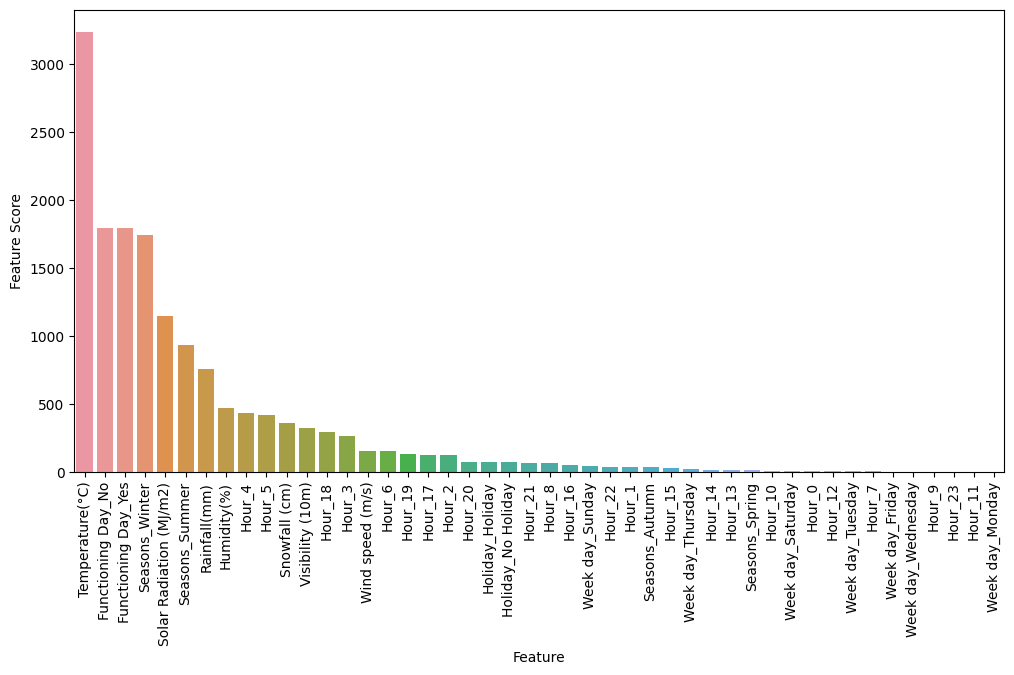

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X, y)

# Create a pandas DataFrame to store the feature scores and sort them
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': fs.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Calculate feature contribution percentages
feature_contribution = (feature_scores['Score'] / feature_scores['Score'].sum()) * 100
feature_scores['Contribution'] = feature_contribution

# Print feature contributions
for i, row in feature_scores.iterrows():
    print(f"{row['Feature']}: {row['Contribution']:.2f}%")

# Plot feature scores in a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Score', data=feature_scores)
plt.xticks(rotation=90)
plt.ylabel('Feature Score')
plt.show()

###***2.7 Feature Scaling***

In [ ]:

#splits the data into training and test dataset (70%-30%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print('The training set has shape of', x_train.shape); print('the testing set has shape of', x_test.shape)

The training set has shape of (6132, 46)
the testing set has shape of (2628, 46)


In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=pd.DataFrame(sc.fit_transform(x_train),columns=list(x_train.columns))
X_test=pd.DataFrame(sc.transform(x_test),columns=list(x_test.columns))
X_test

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Week day_Friday,Week day_Monday,Week day_Saturday,...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,-0.658257,-0.522614,0.931035,-0.227823,1.467228,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,-0.580363,1.726046,-0.22521,0.22521,-0.183143,0.183143
1,1.315812,-0.776637,0.445963,-0.111924,1.593134,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2,0.103078,0.595068,0.064306,-0.415256,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,-0.22521,0.22521,-0.183143,0.183143
3,-0.842085,-0.076302,0.355621,-0.190628,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,4.840483,1.753402,-0.579359,-0.580363,-0.579359,-0.22521,0.22521,-0.183143,0.183143
4,0.144237,0.118120,-0.149531,0.978509,-0.842299,-0.249017,-0.2358,2.484337,-0.395382,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,-0.22521,0.22521,5.460226,-5.460226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623,1.479001,0.547915,0.262059,-0.494757,1.427333,-0.249017,-0.2358,-0.402522,-0.395382,2.423724,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2624,0.776253,1.244144,-0.506838,-1.546242,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2625,0.349795,-1.035745,-0.149531,0.978509,1.120831,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,1.726046,-0.580363,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2626,-1.633255,-1.140983,-0.263335,0.978509,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,-0.580363,1.726046,-0.22521,0.22521,-0.183143,0.183143


In [ ]:
X_train

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Week day_Friday,Week day_Monday,Week day_Saturday,...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,-0.136010,0.782574,0.355621,0.978509,-0.842299,-0.249017,-0.23580,-0.402522,-0.395382,2.423724,...,-0.214198,-0.206591,-0.570320,1.726046,-0.580363,-0.579359,-0.225210,0.225210,-0.183143,0.183143
1,0.579595,0.166382,-0.149531,-0.932980,-0.842299,-0.249017,-0.23580,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,1.726046,-0.580363,-0.579359,-0.225210,0.225210,-0.183143,0.183143
2,-0.425555,0.069723,-1.073734,0.978509,-0.842299,-0.249017,-0.23580,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,-0.225210,0.225210,-0.183143,0.183143
3,0.374437,-0.522614,0.617822,0.978509,-0.842299,-0.249017,-0.23580,-0.402522,2.529202,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,4.440295,-4.440295,5.460226,-5.460226
4,-1.354462,0.829182,-2.505265,0.941294,-0.842299,-0.249017,4.24353,-0.402522,2.529202,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,-0.580363,1.726046,-0.225210,0.225210,-0.183143,0.183143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,0.316932,0.500646,-0.040441,-0.914872,1.417915,-0.249017,-0.23580,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,-0.225210,0.225210,-0.183143,0.183143
6128,0.127775,0.166382,-0.637571,-1.554141,-0.842299,-0.249017,-0.23580,-0.402522,2.529202,-0.412588,...,-0.214198,-0.206591,-0.570320,1.726046,-0.580363,-0.579359,-0.225210,0.225210,-0.183143,0.183143
6129,1.291323,1.152604,-0.920212,-0.976339,-0.417785,-0.249017,-0.23580,2.484337,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.225210,0.225210,-0.183143,0.183143
6130,1.013542,1.289776,-0.506838,-0.217220,-0.842299,-0.249017,-0.23580,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.225210,0.225210,-0.183143,0.183143


In [ ]:
X_test

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Week day_Friday,Week day_Monday,Week day_Saturday,...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,-0.658257,-0.522614,0.931035,-0.227823,1.467228,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,-0.580363,1.726046,-0.22521,0.22521,-0.183143,0.183143
1,1.315812,-0.776637,0.445963,-0.111924,1.593134,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2,0.103078,0.595068,0.064306,-0.415256,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,-0.22521,0.22521,-0.183143,0.183143
3,-0.842085,-0.076302,0.355621,-0.190628,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,4.840483,1.753402,-0.579359,-0.580363,-0.579359,-0.22521,0.22521,-0.183143,0.183143
4,0.144237,0.118120,-0.149531,0.978509,-0.842299,-0.249017,-0.2358,2.484337,-0.395382,-0.412588,...,-0.214198,-0.206591,1.753402,-0.579359,-0.580363,-0.579359,-0.22521,0.22521,5.460226,-5.460226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623,1.479001,0.547915,0.262059,-0.494757,1.427333,-0.249017,-0.2358,-0.402522,-0.395382,2.423724,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2624,0.776253,1.244144,-0.506838,-1.546242,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,1.723059,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2625,0.349795,-1.035745,-0.149531,0.978509,1.120831,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,1.726046,-0.580363,-0.579359,-0.22521,0.22521,-0.183143,0.183143
2626,-1.633255,-1.140983,-0.263335,0.978509,-0.842299,-0.249017,-0.2358,-0.402522,-0.395382,-0.412588,...,-0.214198,-0.206591,-0.570320,-0.579359,-0.580363,1.726046,-0.22521,0.22521,-0.183143,0.183143


In [ ]:
y_test

2004   -0.289910
4573    1.251853
7843    1.335124
8735    0.101205
7229   -2.237130
          ...   
6038    0.104479
5016    0.104479
4090    0.574806
6      -0.751789
5725    0.247540
Name: Rented Bike Count, Length: 2628, dtype: float64

In [ ]:
y_train.reset_index().drop(columns='index')

,Rented Bike Count
0,0.046053
1,0.449809
2,0.879534
3,-2.237130
4,-1.328768
...,...
6127,0.703382
6128,-0.837281
6129,0.314185
6130,0.216099


##***3. Data Modeling***

###***3.1 Linear Regression***

####***3.2.1 Single Linear Regression***

In [ ]:
temp = sm.add_constant(X_train['Temperature(°C)'])
est = sm.OLS(y_train.reset_index().drop(columns='index'), temp)  #Ordinary least squares
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     2270.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        10:24:32   Log-Likelihood:                -7701.3
No. Observations:                6132   AIC:                         1.541e+04
Df Residuals:                    6130   BIC:                         1.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0040      0.011     

>*P value = 0, there is existing parameter of "Rented Bike count" and "Temperature".*

>*R squared is low, the linear does not fit to real points.*

In [ ]:
model=LinearRegression()
model.fit(X_train['Temperature(°C)'].values.reshape(-1,1), y_train.reset_index().drop(columns='index'))
y_pred=model.predict(X_test['Temperature(°C)'].values.reshape(-1,1))
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {(mean_squared_error(y_test,y_pred))}")
print(f"Model RMSE : {(np.sqrt(mean_squared_error(y_test,y_pred)))}")
print(f"Model MAE : {(mean_absolute_error(y_test,y_pred))}")
print(f"Model MAPE : {(mean_absolute_percentage_error(y_test,y_pred))}")
accuracies = cross_val_score(estimator = model, X = X_train['Temperature(°C)'].values.reshape(-1,1), y = y_train.reset_index().drop(columns='index'), cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison={}
model_comparison['Single Linear Regression']=[r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), mean_absolute_error(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred),accuracies.mean(),accuracies.std()]


LinearRegression()

Model R-Square : 26.87%
Model MSE : 0.7499170433009723
Model RMSE : 0.865977507387445
Model MAE : 0.6646525404245457
Model MAPE : 2.7140402766295826
Cross Val Accuracy: 26.97 %
Cross Val Standard Deviation: 2.97 %


####***3.2.2 Multiple Linear Regression***

In [ ]:
temp = sm.add_constant(X_train)
est = sm.OLS(y_train.reset_index().drop(columns='index'), temp)  #Ordinary least squares
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     625.1
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        10:24:32   Log-Likelihood:                -3607.3
No. Observations:                6132   AIC:                             7299.
Df Residuals:                    6090   BIC:                             7581.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
model=LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {(mean_squared_error(y_test,y_pred))}")
print(f"Model RMSE : {(np.sqrt(mean_squared_error(y_test,y_pred)))}")
print(f"Model MAE : {(mean_absolute_error(y_test,y_pred))}")
print(f"Model MAPE : {(mean_absolute_percentage_error(y_test,y_pred))}")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Multiple Linear Regression']=[r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), mean_absolute_error(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred),accuracies.mean(),accuracies.std()]

LinearRegression()

Model R-Square : 81.67%
Model MSE : 0.18798239930166205
Model RMSE : 0.4335693708066358
Model MAE : 0.331201961631755
Model MAPE : 1.8846745047862747
Cross Val Accuracy: 80.52 %
Cross Val Standard Deviation: 0.82 %


In [ ]:
# Get feature importance scores and create DataFrame
importances = abs(model.coef_) / abs(model.coef_).sum()
importance_lr = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort DataFrame by importance score and add gradient background
importance_lr = importance_lr.sort_values('Importance', ascending=False).reset_index(drop=True)
importance_lr = importance_lr.style.background_gradient(cmap='RdYlGn', subset=['Importance'])

# Display the DataFrame with gradient background
importance_lr

,Feature,Importance
0,Holiday_No Holiday,0.053397
1,Holiday_Holiday,0.053397
2,Seasons_Summer,0.045876
3,Seasons_Spring,0.045836
4,Seasons_Winter,0.045836
5,Seasons_Autumn,0.045475
6,Hour_12,0.025105
7,Hour_21,0.024930
8,Hour_22,0.024886
9,Hour_2,0.024709


In [ ]:
# Drop columns with high p value
model=LinearRegression()
model.fit(X_train.drop(columns=['Visibility (10m)','Snowfall (cm)','Hour_1','Hour_9','Week day_Monday']),y_train)
y_pred=model.predict(X_test.drop(columns=['Visibility (10m)','Snowfall (cm)','Hour_1','Hour_9','Week day_Monday']))
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {(mean_squared_error(y_test,y_pred))}")
print(f"Model RMSE : {(np.sqrt(mean_squared_error(y_test,y_pred)))}")
print(f"Model MAE : {(mean_absolute_error(y_test,y_pred))}")
print(f"Model MAPE : {(mean_absolute_percentage_error(y_test,y_pred))}")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Multiple Linear Regression with drop cols']=[r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), mean_absolute_error(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred),accuracies.mean(),accuracies.std()]

LinearRegression()

Model R-Square : 81.67%
Model MSE : 0.18798132679020693
Model RMSE : 0.433568133965363
Model MAE : 0.33123509798032325
Model MAPE : 1.8812097615801275
Cross Val Accuracy: 80.52 %
Cross Val Standard Deviation: 0.82 %


In [ ]:
# Get feature importance scores and create DataFrame
importances = abs(model.coef_) / abs(model.coef_).sum()
importance_lr_drop = pd.DataFrame({'Feature': X.drop(columns=['Visibility (10m)','Snowfall (cm)','Hour_1','Hour_9','Week day_Monday']).columns, 'Importance': importances})

# Sort DataFrame by importance score and add gradient background
importance_lr_drop = importance_lr_drop.sort_values('Importance', ascending=False).reset_index(drop=True)
importance_lr_drop = importance_lr_drop.style.background_gradient(cmap='RdYlGn', subset=['Importance'])

# Display the DataFrame with gradient background
importance_lr_drop

,Feature,Importance
0,Seasons_Summer,0.177738
1,Seasons_Spring,0.177585
2,Seasons_Winter,0.177585
3,Seasons_Autumn,0.176185
4,Functioning Day_No,0.123121
5,Functioning Day_Yes,0.123121
6,Holiday_No Holiday,0.022332
7,Holiday_Holiday,0.022332
8,Temperature(°C),0.000000
9,Rainfall(mm),0.000000


###***3.2 Decision Tree Regression***

In [ ]:
model=DecisionTreeRegressor() 
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {(mean_squared_error(y_test,y_pred))}")
print(f"Model RMSE : {(np.sqrt(mean_squared_error(y_test,y_pred)))}")
print(f"Model MAE : {(mean_absolute_error(y_test,y_pred))}")
print(f"Model MAPE : {(mean_absolute_percentage_error(y_test,y_pred))}")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Decision Tree']=[r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), mean_absolute_error(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred),accuracies.mean(),accuracies.std()]

DecisionTreeRegressor()

Model R-Square : 81.38%
Model MSE : 0.19092326530418818
Model RMSE : 0.43694766883940256
Model MAE : 0.28926486113305006
Model MAPE : 1.5881451843312886
Cross Val Accuracy: 79.54 %
Cross Val Standard Deviation: 1.32 %


In [ ]:
# import export_graphviz
from sklearn.tree import export_graphviz

# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
export_graphviz(model, out_file ='tree.dot',
			feature_names =X_train.columns)


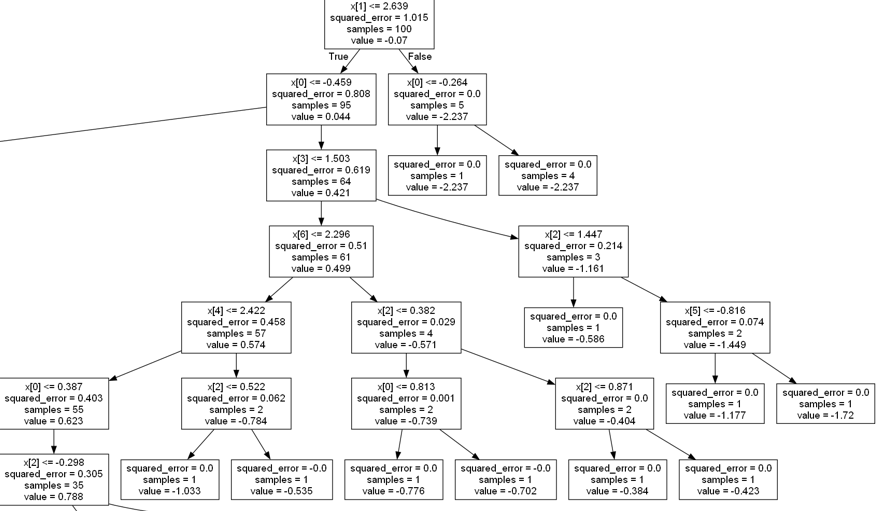

In [ ]:
# Get feature importance scores
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Print feature importance scores
for i in sorted_idx:
    print(f"{X.columns[i]}: {importances[i]}")

Temperature(°C): 0.27865631938120755
Functioning Day_No: 0.21455752702497122
Humidity(%): 0.17200165601700057
Rainfall(mm): 0.03475919558639666
Hour_4: 0.030890400673552636
Solar Radiation (MJ/m2): 0.029978937728911408
Hour_5: 0.028480575343508008
Hour_3: 0.025906281898479468
Hour_18: 0.018520422713005278
Visibility (10m): 0.016167436869182907
Seasons_Autumn: 0.01580296693440999
Hour_2: 0.015486395751677023
Hour_6: 0.014135709670305264
Wind speed (m/s): 0.013284828897886325
Hour_8: 0.007927735962697193
Hour_21: 0.00755559789358952
Hour_17: 0.007237800004072001
Hour_19: 0.007236982086931531
Hour_20: 0.006067520695332778
Seasons_Winter: 0.004909897277781343
Week day_Saturday: 0.004839861556428483
Hour_1: 0.004685985586616137
Week day_Sunday: 0.004638500662708748
Hour_22: 0.004278742528789157
Hour_16: 0.002949959534008664
Seasons_Summer: 0.002607805975765263
Snowfall (cm): 0.0025923629443829243
Hour_7: 0.0023475016145277357
Hour_10: 0.0022137432935917774
Week day_Thursday: 0.0020386067287

In [ ]:
# Get feature importance scores
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Create DataFrame with feature importance scores
importance_tree = pd.DataFrame({'Feature': X.columns[sorted_idx], 'Importance Score': importances[sorted_idx]})

# Add background gradient to DataFrame
importance_tree = importance_tree.style.background_gradient()

# Print DataFrame
importance_tree


,Feature,Importance Score
0,Temperature(°C),0.278656
1,Functioning Day_No,0.214558
2,Humidity(%),0.172002
3,Rainfall(mm),0.034759
4,Hour_4,0.030890
5,Solar Radiation (MJ/m2),0.029979
6,Hour_5,0.028481
7,Hour_3,0.025906
8,Hour_18,0.018520
9,Visibility (10m),0.016167


In [ ]:
model=RandomForestRegressor()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {(mean_squared_error(y_test,y_pred))}")
print(f"Model RMSE : {(np.sqrt(mean_squared_error(y_test,y_pred)))}")
print(f"Model MAE : {(mean_absolute_error(y_test,y_pred))}")
print(f"Model MAPE : {(mean_absolute_percentage_error(y_test,y_pred))}")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Random Forest']=[r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), mean_absolute_error(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred),accuracies.mean(),accuracies.std()]

RandomForestRegressor()

Model R-Square : 91.09%
Model MSE : 0.09134071359129814
Model RMSE : 0.30222626224618226
Model MAE : 0.20858321316991474
Model MAPE : 1.23207292959624
Cross Val Accuracy: 89.87 %
Cross Val Standard Deviation: 0.30 %


In [ ]:
# Get feature importance scores
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Create DataFrame with feature importance scores
importance_forest = pd.DataFrame({'Feature': X.columns[sorted_idx], 'Importance Score': importances[sorted_idx]})

# Add background gradient to DataFrame
importance_forest = importance_forest.style.background_gradient()

# Print DataFrame
importance_forest


,Feature,Importance Score
0,Temperature(°C),0.295461
1,Functioning Day_No,0.188134
2,Humidity(%),0.145369
3,Rainfall(mm),0.054534
4,Solar Radiation (MJ/m2),0.031792
5,Hour_4,0.030077
6,Hour_5,0.028842
7,Hour_3,0.023089
8,Hour_18,0.020687
9,Wind speed (m/s),0.014752


In [ ]:
Model_com_df=pd.DataFrame(model_comparison).T
Model_com_df.columns=['R-Square','MSE','RMSE','MAE','MAPE','CV Accuracy','CV std']
Model_com_df=Model_com_df.sort_values(by='R-Square',ascending=False)
Model_com_df.style.background_gradient(cmap='RdYlBu_r')


,R-Square,MSE,RMSE,MAE,MAPE,CV Accuracy,CV std
Random Forest,0.910931,0.091341,0.302226,0.208583,1.232073,0.898651,0.002994
Multiple Linear Regression with drop cols,0.816694,0.187981,0.433568,0.331235,1.881210,0.805153,0.008209
Multiple Linear Regression,0.816693,0.187982,0.433569,0.331202,1.884675,0.805153,0.008209
Decision Tree,0.815945,0.188750,0.434453,0.286207,1.576562,0.791571,0.018755
Single Linear Regression,0.268735,0.749917,0.865978,0.664653,2.714040,0.269703,0.029663
